# **[ CIS 5450 ] Final Project - Predicting Assistance Funds for U.S. Natural Disasters**
*Soohyun Choi, Jessica Forsstrom, Reed Kienzle*

*Dec 10, 2023*

# Part 1 : Introduction & Project Overview

As climate change becomes a more and more pressing issue for the world, we have noticed in our own lifetimes the increased presence of natural disasters and the devastating impacts they have across the globe. In order to investigate some of the impacts of natural disasters, we decided to also analyze economic data related to areas affected by these disasters.

For our project we found two open data sets from FEMA: the [FEMA Disaster Declarations](https://www.fema.gov/openfema-data-page/disaster-declarations-summaries-v2) and [FEMA Public Assistance Funded Projects](https://www.fema.gov/openfema-data-page/public-assistance-funded-projects-details-v1). The Disaster Declarations is a dataframe that contains all FEMA recognized natural disasters within the United States and specific to the US County. The Public Assistance Funded Projects is a dataframe that contains all of the individual projects funded by FEMA to mitigate and prevent the impacts of natural disasters.

While these datasets provide a lot of information about individual declared natural disasters, the Assistance dataframe specifically contains the amount of money FEMA spends on each project. We found the varying amounts spent on each project to be intriguing, and so our project goal became **to design a predictive model that anticipates the amount of money FEMA will spend on a project** given a variety of features.

In order to reinforce our model, we also found economic information from the [Bureau of Labor Statistics](https://www.bls.gov/data/). This provided us with information on employment and labor force for an area at a given time. We will also use information from BLS containing the [Consumer Price Index (CPI)](https://www.bls.gov/cpi/) for the United States by month to account for things like inflation.

# Part 2 : Data Loading and Preprocessing

In [1]:
from urllib.request import urlopen
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier
import torch
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## 2.1. Loading the Datasets

Our first dataset contains information about the FEMA declared disasters, with each row cooresponding to a designated disaster for a US county (i.e. multiple rows can be labeled with the same disaster, but each row is unique because many different counties were affected).

We load it in from a csv file downloaded directly from FEMA's website.

In [3]:
disaster_df = pd.read_csv("/content/drive/Shareddrives/CIS 5450 Project/datasets/DisasterDeclarationsSummaries.csv")

Our second dataset contains information about FEMA's assistance programs, with each row cooresponding to a project. In this dataset, there can be multiple rows containing the same disaster and county, but each row is an individual project that was funded to mitigate or prevent disaster damages.

We load it in from a csv file also downloaded directly from FEMA's website.

In [4]:
assistance_df = pd.read_csv('/content/drive/Shareddrives/CIS 5450 Project/datasets/PublicAssistanceFundedProjectsDetails.csv')

Our third dataset contains unemployment information by US county by year. Each year is a seperate xlsx file downloaded from the BLS website. The labor statistics are also broken up by US county.

Here, we read each file and concatenate them into one dataframe before exporting the cleaned end product as a csv.

In [ ]:
# This is commented out so we don't run it every time and slow things down
'''
directory_path = '/content/drive/Shareddrives/CIS 5450 Project/datasets/Employment Data'
directory_files = os.listdir(directory_path)

employment_df = pd.DataFrame(columns = ['LAUS Code', 'State FIPS Code', 'County FIPS Code', 'County Name/State Abbreviation', 'Year', 'N\A', 'Labor Force', 'Employed', 'Unemployed', 'Unemployment Rate'])

for file in directory_files:
  if(file.find('.xlsx') != -1):
    next_df = pd.read_excel(os.path.join(directory_path, file),
                            names = ['LAUS Code', 'State FIPS Code', 'County FIPS Code', 'County Name/State Abbreviation', 'Year', 'N\A', 'Labor Force', 'Employed', 'Unemployed', 'Unemployment Rate'])
    next_df = next_df.drop([len(next_df)-3, len(next_df)-2, len(next_df)-1])
    next_df = next_df.drop([0,1,2,3,4])
    employment_df = pd.concat([employment_df, next_df])


employment_df = employment_df.sort_values(['Year', 'State FIPS Code', 'County FIPS Code'], ascending = [True, True, True])
employment_df = employment_df.reset_index()
employment_df = employment_df.drop(columns = ['index', 'N\A'])

employment_df.to_csv('/content/drive/Shareddrives/CIS 5450 Project/datasets/combined_laucnty.csv', index=False)

employment_df.head()
'''

"\ndirectory_path = '/content/drive/Shareddrives/CIS 5450 Project/datasets/Employment Data'\ndirectory_files = os.listdir(directory_path)\n\nemployment_df = pd.DataFrame(columns = ['LAUS Code', 'State FIPS Code', 'County FIPS Code', 'County Name/State Abbreviation', 'Year', 'N\\A', 'Labor Force', 'Employed', 'Unemployed', 'Unemployment Rate'])\n\nfor file in directory_files:\n  if(file.find('.xlsx') != -1):\n    next_df = pd.read_excel(os.path.join(directory_path, file),\n                            names = ['LAUS Code', 'State FIPS Code', 'County FIPS Code', 'County Name/State Abbreviation', 'Year', 'N\\A', 'Labor Force', 'Employed', 'Unemployed', 'Unemployment Rate'])\n    next_df = next_df.drop([len(next_df)-3, len(next_df)-2, len(next_df)-1])\n    next_df = next_df.drop([0,1,2,3,4])\n    employment_df = pd.concat([employment_df, next_df])\n\n\nemployment_df = employment_df.sort_values(['Year', 'State FIPS Code', 'County FIPS Code'], ascending = [True, True, True])\nemployment_df = 

In [5]:
# store the combined dataset as a csv so we don't need to combine them every time
employment_df = pd.read_csv('/content/drive/Shareddrives/CIS 5450 Project/datasets/combined_laucnty.csv')

Our final dataset is the consumer price index of the US by month. We will be using this to discount monetary values so that dollar amounts can be comparable regardless of what year the assistance project took place in.

The xlsx file was downloaded from the BLS website and can be identified by the Series Id in the comment below.

In [6]:
# Data from: https://data.bls.gov/pdq/SurveyOutputServlet
# Series Id: CUSR0000SA0

cpi_df = pd.read_excel('/content/drive/Shareddrives/CIS 5450 Project/datasets/SeriesReport-20231130211153_5b83b9.xlsx')
cpi_df.columns = ['Year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'HALF1', 'HALF2']
cpi_df = cpi_df.drop([0,1,2,3,4,5,6,7,8,9,10])
cpi_df = cpi_df.drop(columns=['HALF1', 'HALF2']).reset_index().drop(columns='index')
cpi_df = pd.melt(cpi_df, 'Year').rename(columns = {'variable' : 'Month', 'value' : 'cpi'})
cpi_df = cpi_df.astype({'Year' : 'int64', 'Month' : 'int64', 'cpi' : 'float'})

cpi_df.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Year,Month,cpi
0,1980,1,78.0
1,1981,1,87.2
2,1982,1,94.4
3,1983,1,97.9
4,1984,1,102.1


## 2.2. Analyzing Data Structures

Now that we have loaded in our datasets, let's get some basic information on the FEMA datasets.

### 2.2.1. Disaster Data

In [ ]:
# How many rows do we have in the dataframe?
len(disaster_df)

64950

In [ ]:
# check for data types
dtype = disaster_df.dtypes

# check for missing values
isna = disaster_df.isna().sum()

d_info_df = pd.DataFrame({"dtype": dtype, "isna": isna}).reset_index()
d_info_df.rename(columns={"index": "column"}, inplace=True)
d_info_df

,column,dtype,isna
0,femaDeclarationString,object,0
1,disasterNumber,int64,0
2,state,object,0
3,declarationType,object,0
4,declarationDate,object,0
5,fyDeclared,int64,0
6,incidentType,object,0
7,declarationTitle,object,0
8,ihProgramDeclared,int64,0
9,iaProgramDeclared,int64,0


Checking the types of the columns, they look good with the exception of the date columns: `incidentBeginDate`, `incidentEndDate`, `disasterCloseoutDate`, `declarationDate`, and `lastIAFilingDate`. The important ones for our model will be converted to type datetime in data preprocessing, section 2.3.1.

However, we do have some columns that have null values. Let's look at these more closely.

In [ ]:
# print only columns with missing values
d_info_df[d_info_df["isna"] > 0]

,column,dtype,isna
13,incidentEndDate,object,539
14,disasterCloseoutDate,object,15984
21,lastIAFilingDate,object,46958


We have 3 columns that have null values. Let's think about what that could mean, and if that will be a problem.


1.   `incidentEndDate`: It looks like a few disasters don't have an end date, but this is to be expected.
2.   `disasterCloseoutDate`: This column only has a value once all financial transactions have closed. It makes sense that there are quite a few null values here, as some disasters can cause damages that takes a very long time to fix.
3.   `lastIAFilingDate`: According to FEMA, data for this column is only available after 1998, which accounts for many of the null values. This column is the last date when IA requests can be filed. IA requests are Individual Assistance requests, and don't tell us anything about the assitance program itself. Thus, we won't use this column, and it doesn't matter if there are null values here.

Overall, there are good explainations for null values and these null values shouldn't interfere with our modeling; however, we deal with these later in section 2.3.1.

### 2.2.2. Assistance Data

In [ ]:
# How many rows do we have in the dataframe?
len(assistance_df)

797674

In [ ]:
# check for data types
dtype = assistance_df.dtypes

# check for missing values
isna = assistance_df.isna().sum()

a_info_df = pd.DataFrame({"dtype": dtype, "isna": isna}).reset_index()
a_info_df.rename(columns={"index": "column"}, inplace=True)
a_info_df

,column,dtype,isna
0,disasterNumber,int64,0
1,declarationDate,object,0
2,incidentType,object,0
3,pwNumber,int64,0
4,applicationTitle,object,6222
5,applicantId,object,0
6,damageCategoryCode,object,0
7,projectSize,object,13008
8,county,object,13008
9,countyCode,float64,13008


Like above, the types are good with the exception of the date column, `declarationDate`, which we will convert to datetime.

Let's also look at these null values more closely.

In [ ]:
# print only columns with missing values
a_info_df[a_info_df["isna"] > 0]

,column,dtype,isna
4,applicationTitle,object,6222
7,projectSize,object,13008
8,county,object,13008
9,countyCode,float64,13008


We have 4 columns that have null values for assistance_df.

The first column, `applicationTitle` won't matter for modeling purposes if it is null in some areas, so we are fine with some null values here.

However, the next three columns, `projectSize`, `county`, and `countyCode` are all very important columns, and having these be null is problem. Luckily the dataframe already has 797,674 rows, so removing 13,008 rows still leaves us with 784,666 rows which is plenty of rows to work with. We will drop these rows in section 2.3.2.

### 2.2.3. Employment Data

In [ ]:
# How many rows do we have in the dataframe?
len(employment_df)

106094

In [ ]:
# check for data types
dtype = employment_df.dtypes

# check for missing values
isna = employment_df.isna().sum()

e_info_df = pd.DataFrame({"dtype": dtype, "isna": isna}).reset_index()
e_info_df.rename(columns={"index": "column"}, inplace=True)
e_info_df

,column,dtype,isna
0,LAUS Code,object,0
1,State FIPS Code,int64,0
2,County FIPS Code,int64,0
3,County Name/State Abbreviation,object,0
4,Year,int64,0
5,Labor Force,int64,0
6,Employed,int64,0
7,Unemployed,int64,0
8,Unemployment Rate,float64,0
9,fipsCode,int64,0


All of the column types appear appropriate, and none show null values.

### 2.2.4. CPI Data

In [ ]:
# How many rows do we have in the dataframe?
len(cpi_df)

528

In [ ]:
# check for data types
dtype = cpi_df.dtypes

# check for missing values
isna = cpi_df.isna().sum()

c_info_df = pd.DataFrame({"dtype": dtype, "isna": isna}).reset_index()
c_info_df.rename(columns={"index": "column"}, inplace=True)
c_info_df

,column,dtype,isna
0,Year,int64,0
1,Month,int64,0
2,cpi,float64,2


All of the columns appear to be of the appropriate type. The cpi column has two null values, but these will be taken care of when merging the dataframes.

## 2.3. Preprocessing

### 2.3.1. Disaster Data

FIPS codes are 5 digit numeric codes the US uses to identify specific US states and counties. Each state has a unique 2 digit code and each county has a 3 digit code that is unique within the state. We are provided with the 2 and 3 digit codes, but we also want the full FIPS code to create a unique identifier for EDA and merging. We will concatinate the two columns to get this.

In [7]:
# create fips code column
disaster_df["fipsCode"] = disaster_df["fipsStateCode"].apply(lambda x: str(x).zfill(2)) + disaster_df["fipsCountyCode"].apply(lambda x: str(x).zfill(3))
disaster_df[["fipsCode", "fipsStateCode", "fipsCountyCode"]].head()

,fipsCode,fipsStateCode,fipsCountyCode
0,04007,4,7
1,04021,4,21
2,44009,44,9
3,20201,20,201
4,31025,31,25


Let's now convert the columns we identified in section 2.2.1 to the correct type.

We will create a new column, `year`, based on the `incidentBeginDate` of the disaster and create a duration column so we can see how long each disaster lasts.

To clean up the rest of the data frame, we will remove some columns and drop null values.

In [8]:
# convert to datetime
disaster_df["incidentBeginDate"] = pd.to_datetime(disaster_df["incidentBeginDate"])
disaster_df["incidentEndDate"] = pd.to_datetime(disaster_df["incidentEndDate"])
disaster_df["declarationDate"] = pd.to_datetime(disaster_df["declarationDate"])
disaster_df["year"] = disaster_df["incidentBeginDate"].dt.year

# create duration column
disaster_df["incidentDuration"] = disaster_df["incidentEndDate"] - disaster_df["incidentBeginDate"]
disaster_df["incidentDuration"] = disaster_df["incidentDuration"].dt.days

# drop unnecessary date columns
disaster_df = disaster_df.drop(columns=["disasterCloseoutDate", "lastIAFilingDate"])

# drop null values
disaster_df = disaster_df.dropna().reset_index(drop=True)

disaster_df[["incidentBeginDate", "declarationDate", "incidentDuration", "year"]].head()

,incidentBeginDate,declarationDate,incidentDuration,year
0,2023-04-14 00:00:00+00:00,2023-04-14 00:00:00+00:00,2.0,2023
1,2023-04-13 00:00:00+00:00,2023-04-13 00:00:00+00:00,3.0,2023
2,2023-06-08 00:00:00+00:00,2023-08-25 00:00:00+00:00,15.0,2023
3,2023-06-08 00:00:00+00:00,2023-08-25 00:00:00+00:00,15.0,2023
4,2023-06-08 00:00:00+00:00,2023-08-25 00:00:00+00:00,15.0,2023


### 2.3.2. Assistance Data

Since `totalObligated` refers to the amount of funds FEMA has given to a particular project, we decided that for interpretability of our model, it makes more sense to remove all the negative values in this column.

Additionally, the Assistance data included the Federated States of Micronesia (FM) which have not been a part of the US for a very long time. We will remove these rows as well.

In [9]:
# remove all negative values from totalObligated
assistance_df = assistance_df[assistance_df['totalObligated'] > 0]

# remove all rows that apply to state 'FM'
assistance_df = assistance_df[assistance_df['stateCode'] != 'FM']

As mentioned in 2.2.2, we will convert the `declarationDate` column into a datetime.

We will also create both a `year` and `month` column based on this date.

In [10]:
# convert to datetime
assistance_df["declarationDate"] = pd.to_datetime(assistance_df["declarationDate"])
assistance_df['year'] = assistance_df['declarationDate'].dt.year
assistance_df['month'] = assistance_df['declarationDate'].dt.month
assistance_df[["declarationDate", 'year', 'month']].head()

,declarationDate,year,month
0,1998-08-26 00:00:00+00:00,1998,8
1,1998-08-26 00:00:00+00:00,1998,8
2,1998-08-26 00:00:00+00:00,1998,8
3,1998-08-26 00:00:00+00:00,1998,8
4,1998-08-26 00:00:00+00:00,1998,8


One subtlety about money we need to take into account is inflation. Generally over time, the purchasing power of a single dollar will become less. So, if we want to compare monetary amounts across many years, we will need to adjust all the amounts to the purchasing power of the dollar to a single point in time.

To do this we will use the US Consumer Price Index (CPI) provided by the BLS. Broadly speaking, this number correlates to the purchasing power of the US dollar at a point in time, so we can use this number to do our discounting and allow us to compare dollar amounts over time without having to worry about inflation.

In [11]:
# What is the earliest years we have for our data?
min_disaster = disaster_df["year"].min()
min_assistance = assistance_df['year'].min()
min_employment = employment_df["Year"].min()

print("Earliest Disaster: ", min_disaster)
print("Earliest Assistance: ", min_assistance)
print("earliest Year of Employment Data: ", min_employment)

Earliest Disaster:  1953
Earliest Assistance:  1998
earliest Year of Employment Data:  1990


Since we will be predicting on rows from `assistance_df`, let's discount everything to the earliest year of that dataframe: January of 1998.

We will be using a simple discount formula of:

$$ Past Dollars = Dollar Amount * \frac{BeginningPeriodCPI} {EndingPeriodCPI} $$


In [12]:
# rename columns of cpi data
cpi_df.rename(columns = {'Year' : 'year', 'Month' : 'month'}, inplace = True)
beginning_cpi = cpi_df[(cpi_df['year'] == 1998) & (cpi_df['month'] == 1)]['cpi'].iloc[0]

# merge data
assistance_df = assistance_df.merge(cpi_df, on=['year', 'month'], how='inner')
assistance_df['discounted_projectAmount'] = assistance_df.apply(lambda x: round(x['projectAmount'] * beginning_cpi / x['cpi'], 2), axis = 1)
assistance_df['discounted_federalShareObligated'] = assistance_df.apply(lambda x: round(x['federalShareObligated'] * beginning_cpi / x['cpi'], 2), axis = 1)
assistance_df['discounted_totalObligated'] = assistance_df.apply(lambda x: round(x['totalObligated'] * beginning_cpi / x['cpi'], 2), axis = 1)

# display new columns
assistance_df[['year', 'month', 'projectAmount', 'federalShareObligated', 'totalObligated', 'discounted_projectAmount', 'discounted_federalShareObligated', 'discounted_totalObligated']].head()

,year,month,projectAmount,federalShareObligated,totalObligated,discounted_projectAmount,discounted_federalShareObligated,discounted_totalObligated
0,1998,8,100000.00,75000.00,80340.00,99143.21,74357.41,79651.65
1,1998,8,423791.13,317843.35,333171.72,420160.12,315120.09,330317.13
2,1998,8,66966.19,50224.64,53975.01,66392.43,49794.32,53512.56
3,1998,8,22305.00,16728.75,17745.86,22113.89,16585.42,17593.81
4,1998,8,19685.50,14764.13,15461.00,19516.84,14637.63,15328.53


Looking at our new discounted values for `totalObligated`, we have found that many rows contain relatively small amounts for a FEMA funded project (i.e. 1 cent), so to further the interpretability of our model and assist with it's predictive power, we are going to remove all rows where the funds from `discounted_totalObligated` are less than $100.

In [13]:
# remove all rows where discounted_totalObligated is less than $100
assistance_df = assistance_df[assistance_df['discounted_totalObligated'] >= 100]

Let's create a FIPS code column in this dataframe as well and drop the rows with null values since we can't have null values in the `countyCode` column for this step.

In [14]:
# drop rows with null values so we can calculate the fips code
assistance_df = assistance_df.dropna()

# create fips code column
assistance_df["fipsCode"] = assistance_df["stateNumberCode"].apply(lambda x: str(x).zfill(2)) + assistance_df["countyCode"].astype(int).apply(lambda x: str(x).zfill(3))
assistance_df[["fipsCode", "stateNumberCode", "countyCode"]].head()

,fipsCode,stateNumberCode,countyCode
0,48465,48,465.0
1,48465,48,465.0
2,48465,48,465.0
3,48465,48,465.0
4,48465,48,465.0


### 2.3.3. Employment Data

Let's create a FIPS code column for the employment data as well, so we can merge this dataframe with the FEMA dataframes.

In [15]:
employment_df['fipsCode'] = employment_df["State FIPS Code"].apply(lambda x: str(x).zfill(2)) + employment_df["County FIPS Code"].apply(lambda x: str(x).zfill(3))
employment_df[["fipsCode", "State FIPS Code", "County FIPS Code"]].head()

,fipsCode,State FIPS Code,County FIPS Code
0,01001,1,1
1,01003,1,3
2,01005,1,5
3,01007,1,7
4,01009,1,9


There are some rows with a "N.A." for the `Labor Force` column. We don't want to include these so we drop those rows.

We also cast the numeric columns to integers.

In [16]:
employment_df = employment_df[employment_df["Labor Force"] != "N.A."].reset_index().drop(columns='index')

employment_df['Labor Force'] = employment_df['Labor Force'].astype('int')
employment_df['Employed'] = employment_df['Employed'].astype('int')
employment_df['Unemployed'] = employment_df['Unemployed'].astype('int')
employment_df['Unemployment Rate'] = employment_df['Unemployment Rate'].astype('float')

In [17]:
employment_df.dtypes

LAUS Code                          object
State FIPS Code                     int64
County FIPS Code                    int64
County Name/State Abbreviation     object
Year                                int64
Labor Force                         int64
Employed                            int64
Unemployed                          int64
Unemployment Rate                 float64
fipsCode                           object
dtype: object

As we can see, the types are now what we want them to be for each column.

# Part 3 : Exploratory Data Analysis

We will split up the EDA by dataframe and investigate various features in each.

## 3.1. Exploring Disaster Data

We will first take a look at various features of `disaster_df`, the dataframe containing information on various FEMA disasters. Our goal is to learn what factors make these disasters different.

### 3.1.1. Number of Incidents by County

Let's get a sense of how the disasters are distributed geographically across the US.

In [19]:
# create a new dataframe to count the number of incidents by county
incident_county_df = disaster_df.groupby("fipsCode").count()["id"].reset_index()
incident_county_df.columns = ["county", "numOfIncidents"]

Now that we have grouped by FIPS code, we can create an interactive heatmap of the US to see this distribution.

In [21]:
# heatmap of number of incidents by county
with urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response:
    counties = json.load(response)

fig = px.choropleth(incident_county_df, geojson=counties, locations="county", color="numOfIncidents",
                    color_continuous_scale="deep",
                    range_color=(min(incident_county_df["numOfIncidents"]), 80), # max: more than 80
                    scope="usa",
                    labels={"numOfIncidents":"Incident Amount"})

fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
print("< Number of Incidents by County >\n")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

We can see from the map above that disasters are not evenly distributed geographically. There are counties with darker shades along the coast and the middle of the US.

This makes sense as we can expect counties closer to the ocean to experience floods and hurricanes while we would not expect landlocked counties to experience these disaster types as frequently. As for the darker patches in the middle of the US, this is roughly an area known as Tornado Alley, a large portion of the mainline US famous for the frequency of tornados.

### 3.1.2. Number of Counties by State

As we can see above, not all US states have the same number of counties. Let's take a look and see what states have the most number of counties, and which ones have the least.

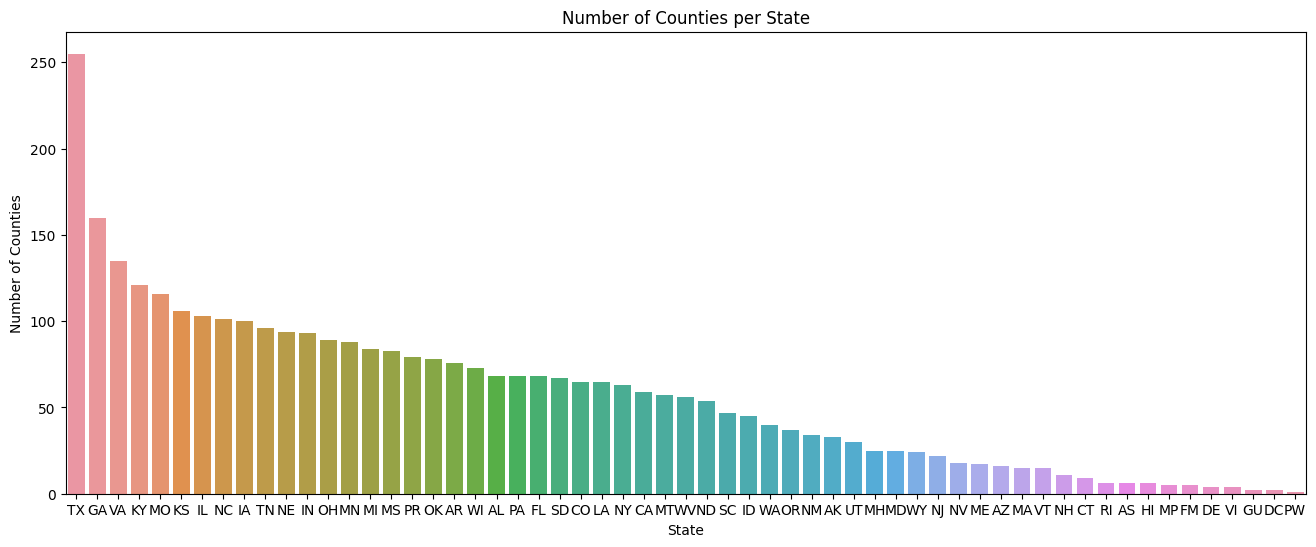

In [ ]:
county_df = disaster_df[['state', 'fipsCountyCode']].drop_duplicates()

plt.figure(figsize = (16, 6))
sns.countplot(x='state', data=county_df, order = county_df['state'].value_counts().index).set(title='Number of Counties per State', xlabel='State', ylabel='Number of Counties')
plt.show()

It looks like Texas (TX) has by far the most amount of counties, with Washington, D.C. having the lowest number (excluding Palau (PW) which hasn't been a part of the US since 1994 and won't be included in our final model after combining our datasets).

### 3.1.3. Number of Incidents by State

Now, let's group by state and look at the total number of incidents each state has recorded in the dataset.

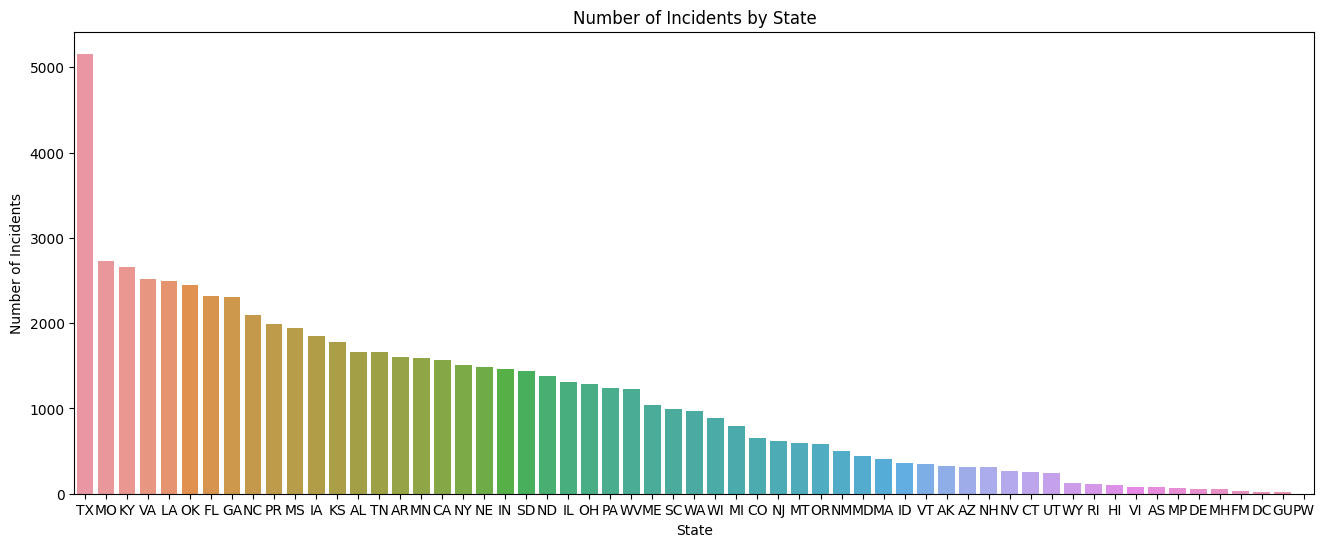

In [ ]:
plt.figure(figsize = (16,6))
sns.countplot(x='state', data=disaster_df, order = disaster_df['state'].value_counts().index).set(title='Number of Incidents by State', xlabel='State', ylabel='Number of Incidents')
plt.show()

Interestingly, there are quite a few things to note when comparing this graph to the county heatmap.





*   Texas (TX) has by far the most amount of disasters compared to any other state. This was not immediately obvious in the heatmap because of how large Texas is and how many counties it has
*   Maine (ME) looked like it had a lot of disasters on the heatmap with some of the darkest colors, but in terms of total incidents, it is slighly below the median. This was a symptom of it having very few counties, so each county had more total incidents, as we can see in the chart for 2.1.2.
*   There appears to be some amount of correlation between number of disasters and number of counties, with states such as TX, MO, VA, and KY showing up in the top 5 of both charts, and states such as DC, DE, and VI showing up near the bottom of both. It is a fair guess to make that state size is correlated to both features, so more investigation would need to be done to verify this.



### 3.1.4. Number of Incidents by Incident Type

Each incident is assigned an incident type. Let's group by these incident types and look at their distribution.

In [22]:
# create a new dataframe to count the number of incidents by incident type
incident_type_df = disaster_df.groupby("incidentType").count()["id"].reset_index()
incident_type_df.rename(columns={"id": "numOfIncidents"}, inplace=True)
incident_type_df = incident_type_df.sort_values(by="numOfIncidents", ascending=False).reset_index(drop=True)

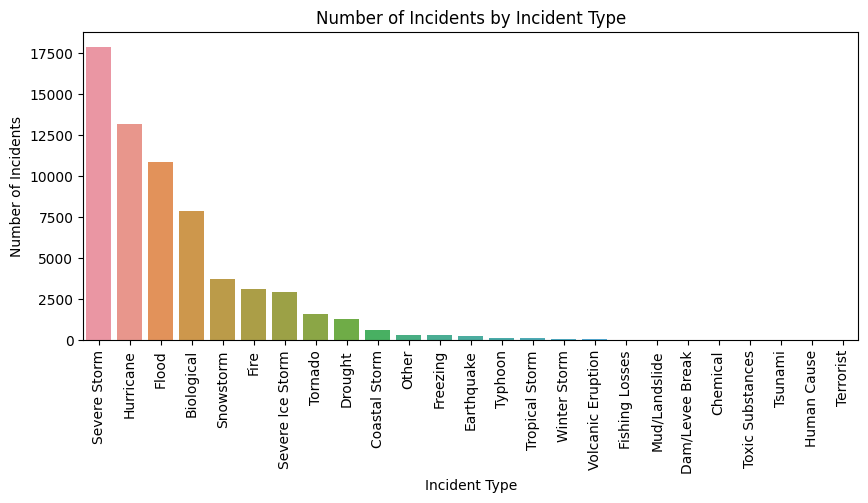

In [ ]:
# barplot of number of incidents by incident type
plt.figure(figsize=(10, 4))
sns.barplot(x="incidentType", y="numOfIncidents", data=incident_type_df)
plt.xticks(rotation=90)

plt.title("Number of Incidents by Incident Type")
plt.xlabel("Incident Type")
plt.ylabel("Number of Incidents")
plt.show()

It looks like the top three incident types are `Severe Storm`, `Hurricane`, and `Flood` in that order with the other types dropping off fairly quickly. Let's take a look at Texas's distribution of incident types to see if it matches the overall distribution.

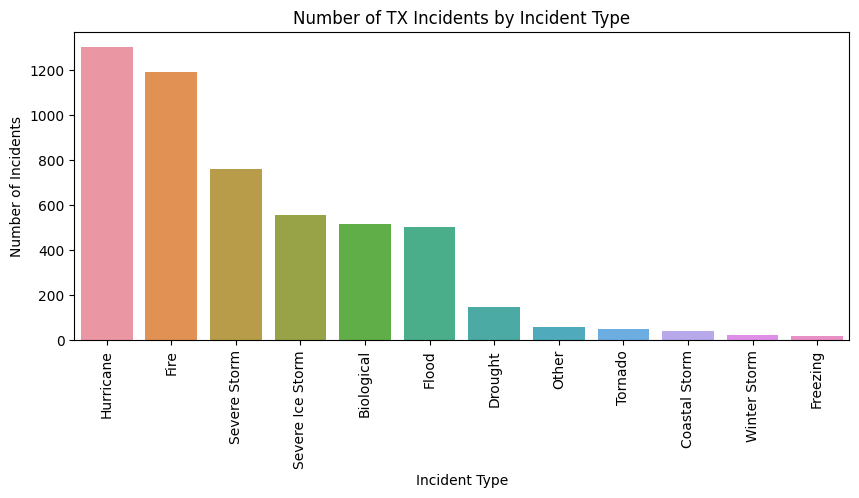

In [ ]:
# since TX has by far the largest total number of incidents, let's look at the incident types for
# that state and compare it to the national totals

tmp_df = disaster_df[disaster_df['state'] == 'TX']

plt.figure(figsize = (10, 4))
plt.xticks(rotation='vertical')
sns.countplot(x='incidentType', orient='v', data=tmp_df, order = tmp_df['incidentType'].value_counts().index).set(title='Number of TX Incidents by Incident Type', xlabel='Incident Type', ylabel="Number of Incidents")
plt.show()

Interestingly, Texas's distribution does not match the country-wide distribution. `Hurricane` is now the top incident type with `Severe Storm` being the third most common incident type. Perhaps the most interesting incident type is that `Fire`, which was the 6th most common incident type overall is the second most common incident type in Texas, appearing close to the number of hurricanes.

Clearly, location has some sort of influence on the disaster types we can expect. One would expect floods to be more common in locatons near the sea or other large bodies of water, and tornados are known to happen far more often in the central continental US.

### 3.1.5. Duration of Incidents by Incident Type

Now, let's look at the duration of various incidents. It is likely that the length of a disaster could be related to how many assistance projects are needed or how much those projects cost.

In [ ]:
# drop null values in duration column
duration_df = disaster_df.dropna(subset=["incidentDuration"]).reset_index(drop=True)

# create a new dataframe to compute average duration by incident type
duration_df = duration_df.groupby("incidentType").mean(numeric_only=True)["incidentDuration"].reset_index()
duration_df = duration_df.sort_values(by="incidentDuration", ascending=False).reset_index(drop=True)

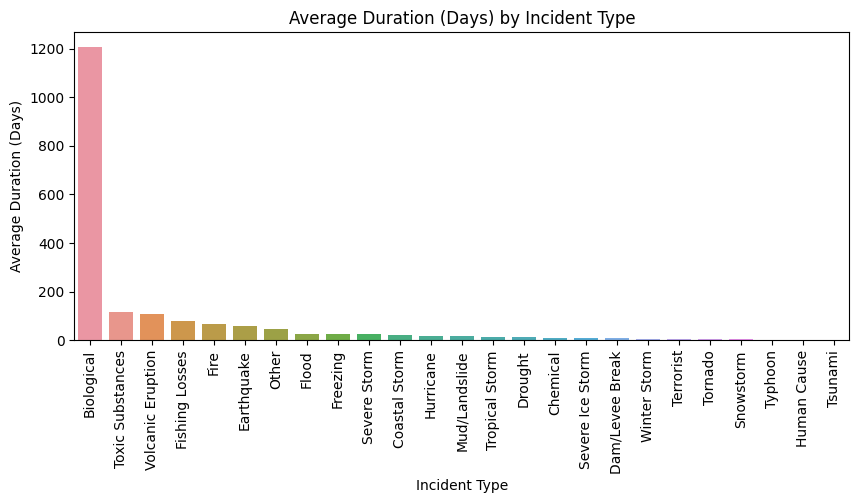

In [ ]:
# barplot of average duration by incident type
plt.figure(figsize=(10, 4))
sns.barplot(x="incidentType", y="incidentDuration", data=duration_df)
plt.xticks(rotation=90)

plt.title("Average Duration (Days) by Incident Type")
plt.xlabel("Incident Type")
plt.ylabel("Average Duration (Days)")
plt.show()

Obviously, something is unique concerning `Biological` incidents based on this chart. Let's look at these incidents more closely.

In [ ]:
# check declarelation title for biological incidents
disaster_df[disaster_df["incidentType"] == "Biological"]["declarationTitle"].unique()

array(['COVID-19 PANDEMIC', 'COVID-19', 'COVID-19 '], dtype=object)

As we can see here, all of the `Biological` incidents are due to COVID-19. That explains the extreme difference in length of these incidents compared to incident types such as `Fire` or `Earthquake`.

But since the length of COVID-19 is so much longer than any other incident, it makes it hard to compare the other incident types. So, let's make the same chart excluding COVID-19.

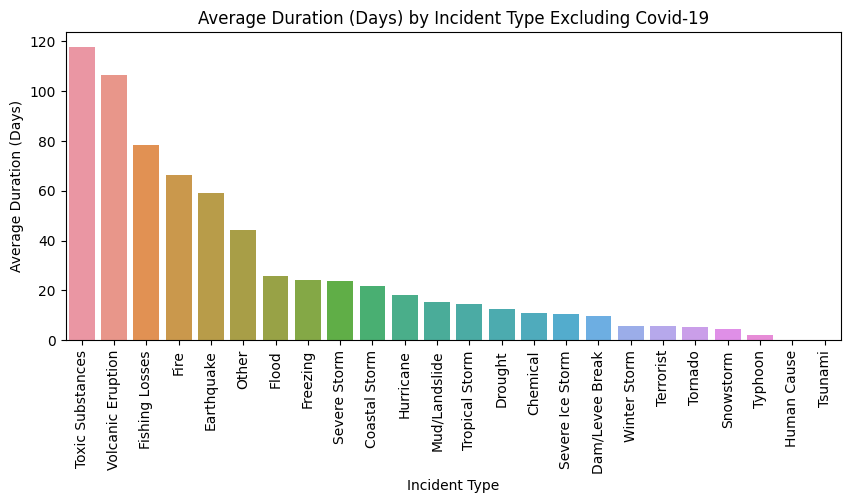

In [ ]:
# barplot of average duration by incident type excluding Covid-19
plt.figure(figsize=(10, 4))
sns.barplot(x="incidentType", y="incidentDuration", data=duration_df[duration_df["incidentType"] != "Biological"])
plt.xticks(rotation=90)

plt.title("Average Duration (Days) by Incident Type Excluding Covid-19")
plt.xlabel("Incident Type")
plt.ylabel("Average Duration (Days)")
plt.show()

Excluding COVID-19 allows us to see far more clearly that different incident types tend to have very different average durations.

This also matches our general intuition. For example, we would expect toxic substances such as an oil spill to last for much longer than a tornado, and the data supports this.

### 3.1.6. Number of Incidents by Year

Let's look at the total number of incidents by year. Before looking at the data, we expect a gradual rise in the total number of disasters due to global warming. Based on the results from above, we can probably also expect a spike in incidents around the COVID-19 pandemic.

In [51]:
# create a new dataframe to count the number of incidents by year
declaration_df = disaster_df.copy()
declaration_df["declarationYear"] = declaration_df["declarationDate"].dt.year

declaration_total_df = declaration_df.groupby("declarationYear").count()["id"].reset_index()
declaration_total_df.rename(columns={"id": "numOfIncidents"}, inplace=True)

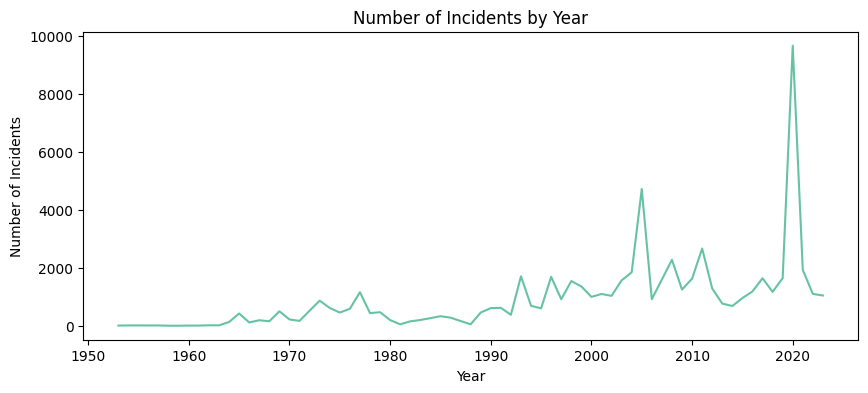

In [52]:
# lineplot of number of incidents by year
plt.figure(figsize=(10, 4))
sns.lineplot(x="declarationYear", y="numOfIncidents", data=declaration_total_df)

plt.title("Number of Incidents by Year")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.show()

Overall, the chart matches our intuition with a gradual upwards trend and a very large spike around 2019/2020.

Let's break this down even further and look at the trends for the top incident types.

In [53]:
# create a new dataframe to count the number of top 5 incidents by year
top_incidents = incident_type_df["incidentType"][:5].to_list()
declaration_type_df = declaration_df[declaration_df["incidentType"].isin(top_incidents)]

declaration_type_df = declaration_type_df.groupby(["declarationYear", "incidentType"]).count()["id"].reset_index()
declaration_type_df.rename(columns={"id": "numOfIncidents"}, inplace=True)


# create a new dataframe to count the number of top 5 incidents by year excluding Covid-19
top_incidents2 = incident_type_df[incident_type_df['incidentType'] != "Biological"]["incidentType"][:5].to_list()
declaration_type_df2 = declaration_df[declaration_df["incidentType"].isin(top_incidents2)]

declaration_type_df2 = declaration_type_df2.groupby(["declarationYear", "incidentType"]).count()["id"].reset_index()
declaration_type_df2.rename(columns={"id": "numOfIncidents"}, inplace=True)

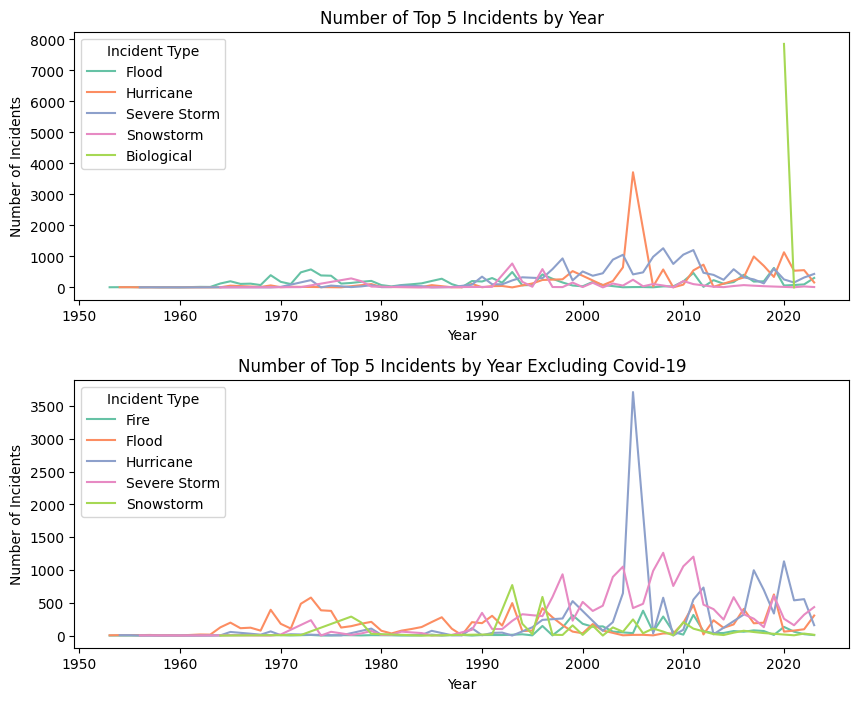

In [54]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(10, 8)
plt.subplots_adjust(hspace=0.3)
sns.set_palette("Set2")

# lineplot of number of top 5 incidents by year
sns.lineplot(ax=ax[0], x="declarationYear", y="numOfIncidents", hue="incidentType", data=declaration_type_df)
ax[0].set_title("Number of Top 5 Incidents by Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Number of Incidents")
ax[0].legend(title="Incident Type")

# lineplot of number of top 5 incidents by year excluding Covid-19
sns.lineplot(ax=ax[1], x="declarationYear", y="numOfIncidents", hue="incidentType", data=declaration_type_df2)
ax[1].set_title("Number of Top 5 Incidents by Year Excluding Covid-19")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Number of Incidents")
ax[1].legend(title="Incident Type", loc="upper left")

plt.show()

Due to the anomoly of COVID-19 incidents skewing the y-axis of the chart, we remade this chart excluding COVID-19.

Interestingly, the general upwards trend seen in the aggregate chart is less pronounced here, but there are certainly more incidents after 1990 than before.

Another interesting observation is the large spike in the `Hurricane` type in 2005. This coincides with Hurricane Katrina, a notorious US hurricane. This, along with the impact we've seen COVID-19 have on the data, lets us know that certain single large-scale disasters can have substantial impacts on the overall data.

## 3.2. Exploring Assistance Data

Now we will look at `assistance_df`, the dataframe that contains information on assistance projects that were funded to help mitigate or prevent disasters.

### 3.2.1. Projects by Project Size

Every project FEMA funds is classified as either a `Large` or `Small` project. Let's see how many of each classification we have.

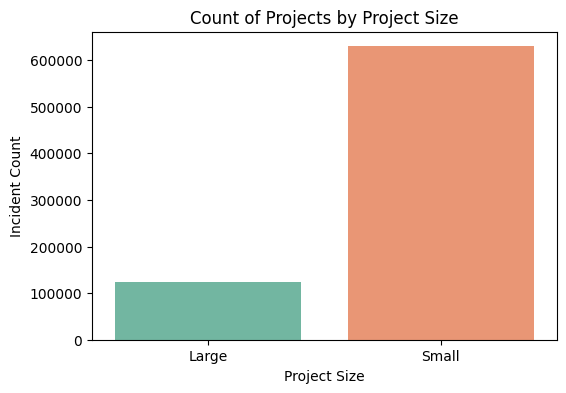

In [56]:
plt.figure(figsize = (6,4))
sns.set_palette("Set2")
sns.countplot(x='projectSize', data=assistance_df).set(title='Count of Projects by Project Size', xlabel='Project Size', ylabel='Incident Count')
plt.show()

Each project is also classified with a damage category that describes what kind of damages the project is funding. Let's look at this distribution as well.

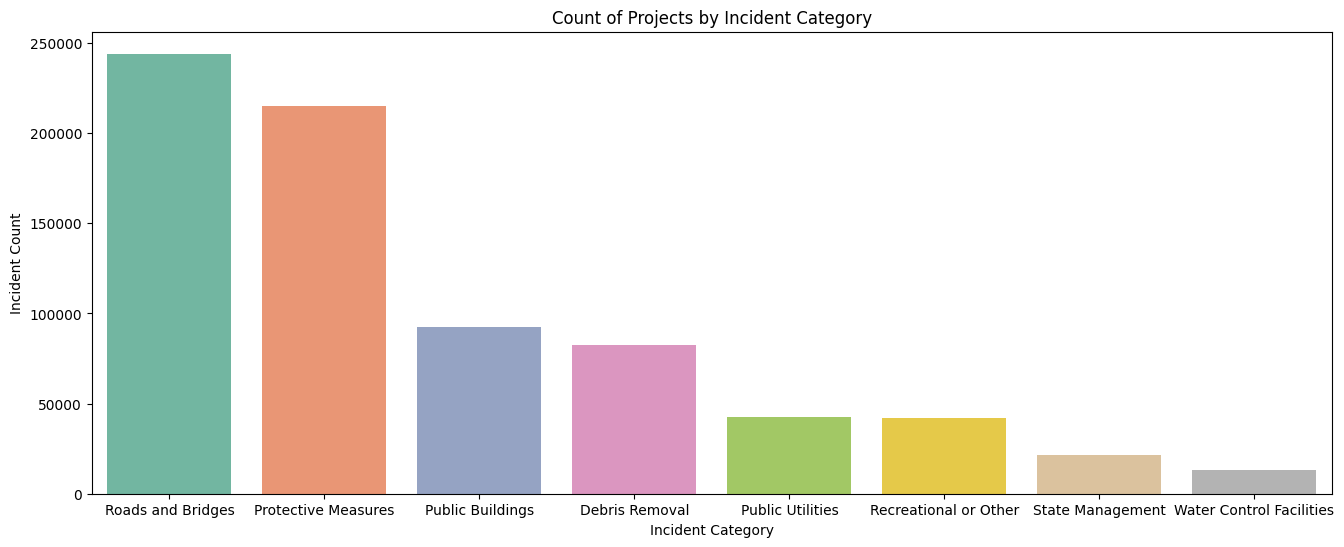

In [55]:
plt.figure(figsize = (16, 6))
sns.set_palette("Set2")
sns.countplot(x='damageCategory', data=assistance_df, order = assistance_df['damageCategory'].value_counts().index).set(title='Count of Projects by Incident Category', xlabel='Incident Category', ylabel='Incident Count')
plt.show()

Now let's see if there seems to be any correlation between the incident category and the project size.

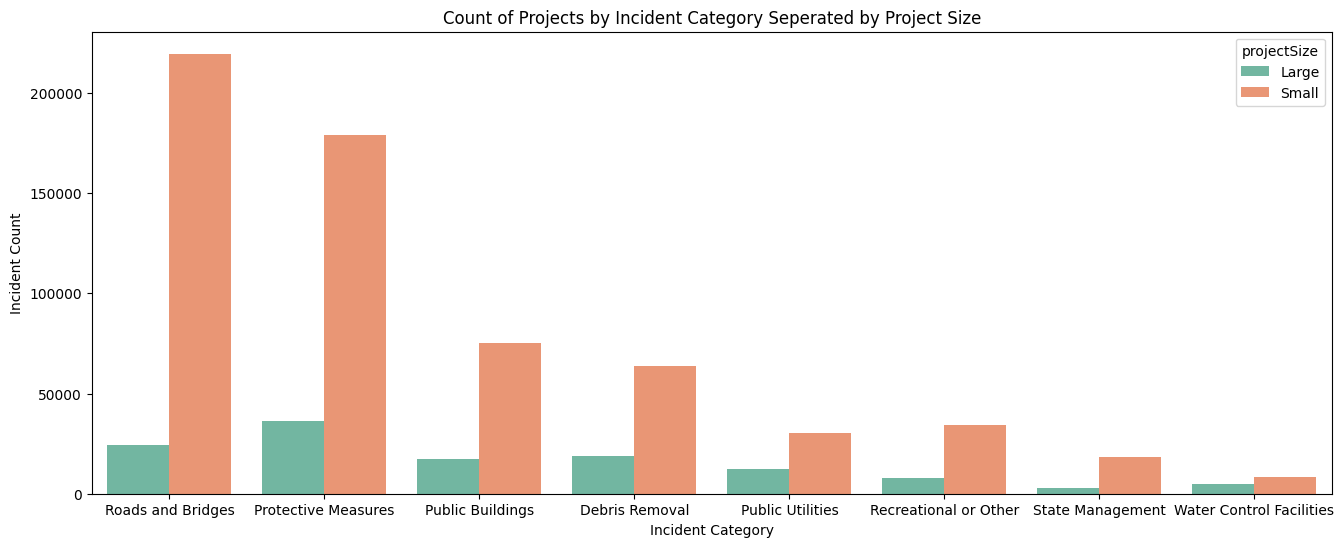

In [57]:
plt.figure(figsize = (16,6))
sns.set_palette("Set2")
sns.countplot(x='damageCategory', hue='projectSize', data=assistance_df, order = assistance_df['damageCategory'].value_counts().index).set(title='Count of Projects by Incident Category Seperated by Project Size', xlabel='Incident Category', ylabel='Incident Count')
plt.show()

Suprisingly, there does not seem to be much of a correlation between these two features. Although there is some variation, each incident cateogry roughly matches the aggregate distribution of `Large` and `Small` project sizes.

This means that we can treat these two features as roughly independent of each other.

### 3.2.2. Total Obligated Funds by Year

Every FEMA project has a "Total Obligated" amount which is define by FEMA as "the federal share of the Public Assistance grant eligible project amount in dollars, plus grantee (State) and sub-grantee (applicant) administrative costs."

In short, we can treat this amount as how much money the project actually cost the federal government (as opposed to some monetary columns that include things like the predicted cost).

Let's look at how both the raw total and the discounted total we calculated with the CPI data changes over time.

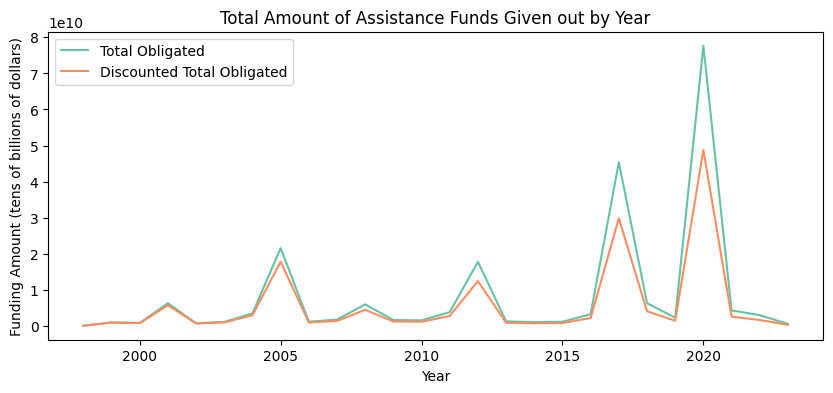

In [28]:
obligated_df = assistance_df.groupby('year')[['totalObligated', 'discounted_totalObligated']].sum()

plt.figure(figsize=(10, 4))
plt.plot(obligated_df)
plt.title('Total Amount of Assistance Funds Given out by Year')
plt.xlabel('Year')
plt.ylabel('Funding Amount (tens of billions of dollars)')
plt.legend(['Total Obligated', 'Discounted Total Obligated'])
plt.show()

From this graph, we can see there does not seem to be an overall positive or negative trend that spans the whole period. Instead, it looks like the total amount of funds given out spike in years when there are serious disasters, such as in 2005 with Hurricane Katrina, and 2020 with COVID-19.

Additionally, the discounted funds look as we would expect, being less than the undiscounted amount. This  gap increases the further from 1998 we go.

From here on out, we are going to analyze the `discounted_totalObligated` column, but it may still be referred to as the total obligated amount.

### 3.2.3. Average FEMA Funds by Month

Let's now look at how variance among features is related to the amount of funds given out for a project. Due to the seasonal nature of natural disasters, we want to consider the month as a feature when trying to predict the amount of funds for our model.

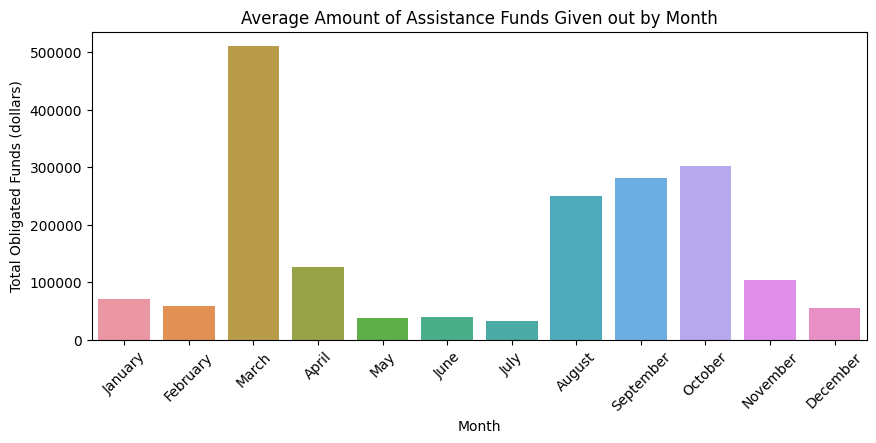

In [30]:
month_names = {1 : "January", 2 : "February", 3 : "March", 4 : "April", 5 : "May", 6 : "June",
          7 : "July", 8 : "August", 9 : "September", 10 : "October", 11 : "November", 12 : "December"}

monthly_df = assistance_df.groupby('month')[['discounted_totalObligated']].mean().sort_values('month').reset_index()
monthly_df['monthNames'] = monthly_df['month'].apply(lambda x : month_names[x])

plt.figure(figsize=(10, 4))
sns.barplot(data = monthly_df, x = 'monthNames', y = 'discounted_totalObligated')
plt.title('Average Amount of Assistance Funds Given out by Month')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Obligated Funds (dollars)')
plt.show()


This graph shows us that the month with the highest average amount of funds given out is March. This makes sense as it correlates with the start of the spring season where there are often many storms and showers. Late summer to fall also has a large amount of funds given out.

Due to the various amounts of funds given out over the course of the year, we want to consider the month as a feature when trying to predict the amount of funds for our model.

### 3.2.4. Total Funds given to Each State

We were curious to see which states have received the highest amount of funding.

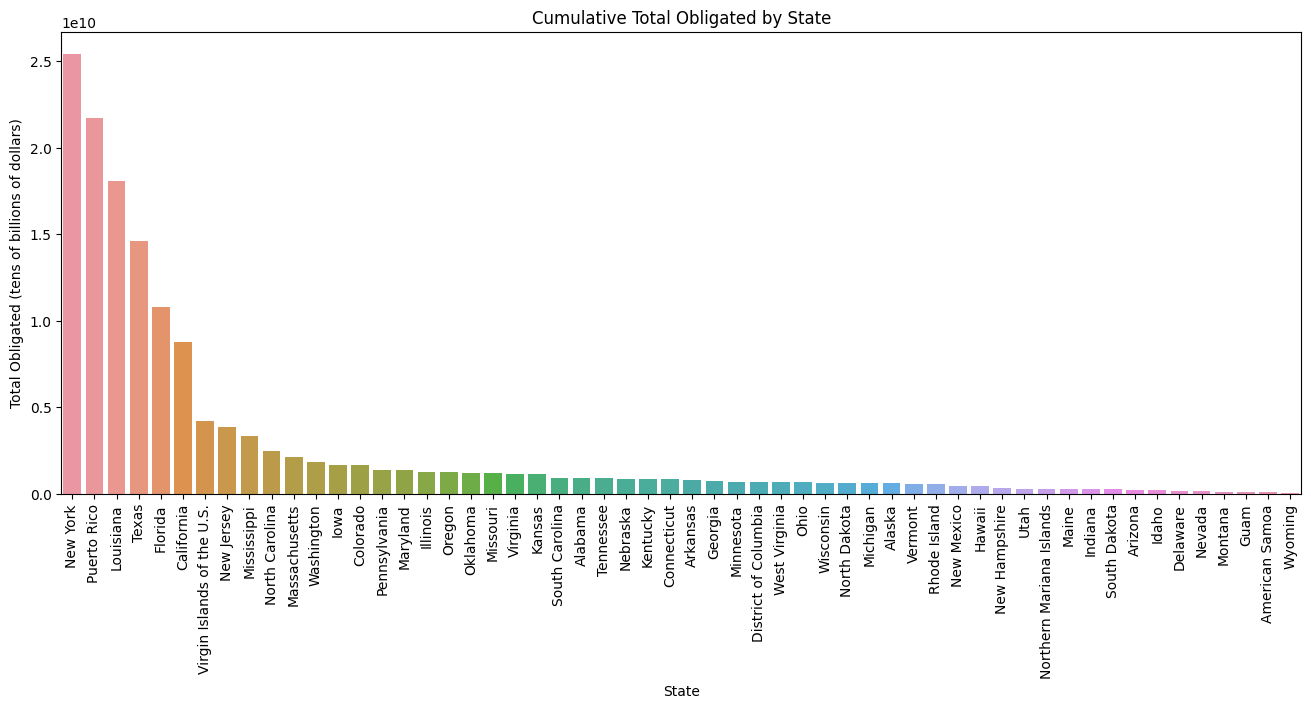

In [29]:
funding_state_df = assistance_df.groupby(['state'])[['discounted_totalObligated']].sum().sort_values('discounted_totalObligated', ascending=False).reset_index()

plt.figure(figsize = (16,6))
sns.barplot(data = funding_state_df, x = 'state', y = 'discounted_totalObligated')
plt.title('Cumulative Total Obligated by State')
plt.xlabel('State')
plt.ylabel('Total Obligated (tens of billions of dollars)')
plt.xticks(rotation = 90)
plt.show()

It seems the cumulative total obligated does not align perfectly with the number of projects. Logically we know that not all projects are equal, and some are far more expensive than others. The chart above confirms that simply the number of projects funded does not fully explain how much money was fully spent on these projects.

### 3.2.5. Total Obligated Per Year for the Top 6 States

We want to dig a little deeper into the cumulative total obligated. To do this, let's look at the top 6 states in terms of cumulative total obligated since there seems to be a larger gap between the top 6 states and the rest of the states.

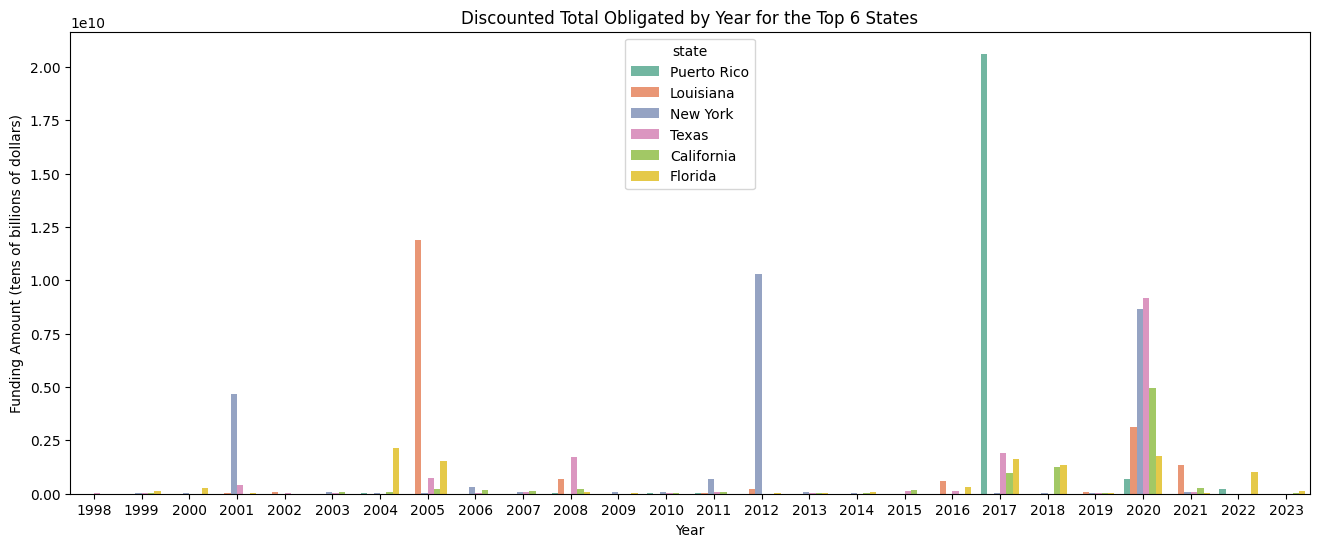

In [31]:
states_to_filter = ['New York', 'Puerto Rico', 'Louisiana', 'Texas', 'Florida', 'California']
top_states_df2 = assistance_df[assistance_df['state'].isin(states_to_filter)]
top_states_df = top_states_df2.groupby(['year', 'state'])[['discounted_totalObligated']].sum().sort_values('discounted_totalObligated', ascending=False).reset_index()

plt.figure(figsize = (16,6))
sns.set_palette("Set2")
sns.barplot(data = top_states_df, x = 'year', y = 'discounted_totalObligated', hue = 'state').set(title='Discounted Total Obligated by Year for the Top 6 States')
plt.xlabel('Year')
plt.ylabel('Funding Amount (tens of billions of dollars)')
plt.show()

What this chart tells us is very interesting. Instead of a constant stream of incidents, most of FEMA's money is being spent on a handful of isolated incidents that cause a lot of expensive projects. This also tells us that our data cannot be treated as time series data since disasters do not occur continuously.

With this graph we can identify which individual disasters most likely caused the large spike in total obligated via a quick web search and then compare with our dataframes. For example, searching "Puerto Rico 2017 disaster" would lead you to conclude that the spike in funding for Puerto Rico is due to mainly Hurricane Maria and Hurricane Irma. We can check this assumption below.

In [ ]:
check_df = assistance_df[assistance_df['state'] == 'Puerto Rico']
check_df = check_df[check_df['year'] == 2017]

disaster_df[disaster_df['disasterNumber'].isin(check_df['disasterNumber'].unique())][['disasterNumber', 'declarationTitle']].drop_duplicates()

,disasterNumber,declarationTitle
5540,4339,HURRICANE MARIA
5844,4336,HURRICANE IRMA
14399,3384,HURRICANE IRMA


In fact, Hurricanes Maria and Irma are the only disasters in Puerto Rico in 2017 that FEMA provided funding for.

Let's now look at the two spikes for New York to see if we observe the same phenomenon.

In [ ]:
check_df = assistance_df[assistance_df['state'] == 'New York']
check_df = check_df[check_df['year'] == 2012]

disaster_df[disaster_df['disasterNumber'].isin(check_df['disasterNumber'].unique())][['disasterNumber', 'declarationTitle']].drop_duplicates()

,disasterNumber,declarationTitle
9348,4085,HURRICANE SANDY


In [ ]:
check_df = assistance_df[assistance_df['state'] == 'New York']
check_df = check_df[check_df['year'] == 2001]

disaster_df[disaster_df['disasterNumber'].isin(check_df['disasterNumber'].unique())][['disasterNumber', 'declarationTitle']].drop_duplicates()

,disasterNumber,declarationTitle
21906,3170,SNOW
38624,1391,FIRES AND EXPLOSIONS


There are two years where funding for New York spikes: 2001 and 2012.

For 2012 we see that Hurricane Sandy was the cause of every project, so that matches what we saw in Puerto Rico.

2001 does not follow the trend and instead, many smaller projects were aggregated under the titles `SNOW` and `FIRES AND EXPLOSIONS`

Overall, while we cannot say that every FEMA project is due to a small amount of highly expensive disasters, we can conclude that a small number of expensive disasters are driving many of the largest amounts of FEMA spending.

### 3.2.6. Average Funds by Incident Type

Now let's look at average total obligated by incident type. This should give us some insight into how expensive different incident types are on average.

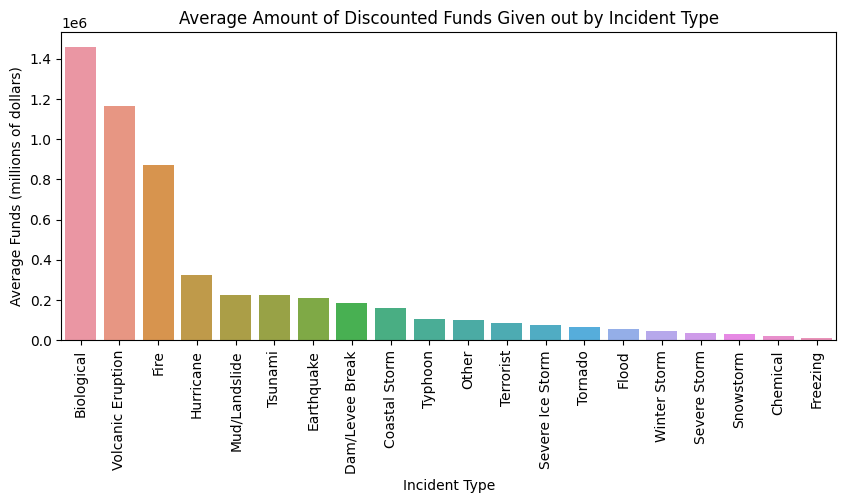

In [32]:
incident_funds = assistance_df.groupby(['incidentType'])[['discounted_totalObligated']].mean().sort_values('discounted_totalObligated', ascending=False).reset_index()

plt.figure(figsize = (10,4))
sns.barplot(data = incident_funds, x = 'incidentType', y = 'discounted_totalObligated')
plt.title('Average Amount of Discounted Funds Given out by Incident Type')
plt.xlabel('Incident Type')
plt.ylabel('Average Funds (millions of dollars)')
plt.xticks(rotation = 90)
plt.show()

We can see that certain incident types generally cost more money even if they are not that common. The clearest examples of this being `Biological` and `Volcanic Eruption`.

- For `Biological`, we have seen many times now that COVID-19 has caused FEMA to issue many expensive projects over a relativly long time period.

- For `Volcanic Eruption`, we have seen above that there are relativly few Volcanic Eruptions, but each one causes a lot of destruction, and thus, costs FEMA a lot of money.

### 3.2.7. Top Counties by Total Projects and Discounted Total Obligated

Let's now take a look at projects by county. We will look at what the top counties are in terms of how many projects have been funded for those counties, and how much money has been spent on those counties. Afterwards, we can compare to see if any trends emerge.

First, we will rank counties by total number of projects and total obligated.

In [33]:
# for this EDA, we want to ignore state-wide assistance programs
top_project_df = assistance_df[assistance_df['countyCode'] != 0.0]

# create a new dataframe to find the top ten counties with the most projects
top_project_df = top_project_df.groupby("fipsCode").count()["id"].reset_index()
top_project_df.columns = ["fipsCode", "Project Count"]
top_project_df = top_project_df.sort_values(["Project Count", 'fipsCode'], ascending = [False, True]).reset_index().drop(columns='index')
top_project_df['Project Rank'] = top_project_df['Project Count'].rank(method='max', ascending=False).astype('int')

top_project_df.head()

,fipsCode,Project Count,Project Rank
0,12086,7301,1
1,48201,6240,2
2,12099,4520,3
3,22071,4130,4
4,12011,3598,5


In [34]:
# for this EDA, we want to ignore state-wide assistance programs
top_cost_df = assistance_df[assistance_df['countyCode'] != 0.0]

# create a new dataframe to find the top ten counties by total Obligated
top_cost_df = top_cost_df.groupby("fipsCode").sum(numeric_only = True)["discounted_totalObligated"].reset_index()
top_cost_df.columns = ["fipsCode", "discounted_totalObligated"]
top_cost_df = top_cost_df.sort_values(["discounted_totalObligated", "fipsCode"], ascending = [False, True]).reset_index().drop(columns='index')
top_cost_df['Obligated Rank'] = top_cost_df['discounted_totalObligated'].rank(method='max', ascending=False).astype('int')

top_cost_df.head()

,fipsCode,discounted_totalObligated,Obligated Rank
0,36061,1.578894e+10,1
1,22071,4.371155e+09,2
2,48201,1.941507e+09,3
3,22033,1.601205e+09,4
4,22087,1.514068e+09,5


Next, we merge the two dataframes we generated.

In [35]:
# merge the two dataframes as well as fips_df to get the state and county names for readability
combined_df = top_project_df.merge(right = top_cost_df, on = 'fipsCode', how = 'inner')
combined_df = combined_df.merge(assistance_df[['state', 'county', 'fipsCode']], on = 'fipsCode', how = 'inner').drop_duplicates()
combined_df = combined_df.reset_index().drop(columns = 'index')

combined_df.head()

,fipsCode,Project Count,Project Rank,discounted_totalObligated,Obligated Rank,state,county
0,12086,7301,1,1.355137e+09,7,Florida,Miami-Dade
1,48201,6240,2,1.941507e+09,3,Texas,Harris
2,12099,4520,3,4.712451e+08,21,Florida,Palm Beach
3,22071,4130,4,4.371155e+09,2,Louisiana,Orleans
4,12011,3598,5,5.651280e+08,16,Florida,Broward


Now that we have a dataframe with the information we want, let's first look at the top 10 counties with the most projects.

In [36]:
# show the top 10 counties by total incidents
project_display_df = combined_df.sort_values('Project Rank', ascending=True)[:10]
project_display_df

,fipsCode,Project Count,Project Rank,discounted_totalObligated,Obligated Rank,state,county
0,12086,7301,1,1.355137e+09,7,Florida,Miami-Dade
1,48201,6240,2,1.941507e+09,3,Texas,Harris
2,12099,4520,3,4.712451e+08,21,Florida,Palm Beach
3,22071,4130,4,4.371155e+09,2,Louisiana,Orleans
4,12011,3598,5,5.651280e+08,16,Florida,Broward
5,34003,3414,6,1.916587e+08,44,New Jersey,Bergen
6,48167,3108,7,3.577447e+08,27,Texas,Galveston
7,36025,2919,8,9.468679e+07,98,New York,Delaware
8,36007,2880,9,1.582828e+08,56,New York,Broome
9,36119,2844,10,2.540682e+08,31,New York,Westchester


Let's also use the US heatmap to visualize where the top 25 counties are located geographically

In [37]:
#Show the top 25 counties by total incidents
project_heatmap_df = combined_df.sort_values('Project Rank', ascending=True)[:25]

# heatmap of number of incidents by county
with urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response:
    counties = json.load(response)

fig = px.choropleth(project_heatmap_df, geojson=counties, locations="fipsCode", color="Project Count",
                    color_continuous_scale="deep",
                    range_color=(min(project_heatmap_df["Project Count"]), 8000), # max: more than 80
                    scope="usa",
                    labels={"Project Count":"Number of Projects"})

fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
print("< Top 25 Counties by Number of Projects >\n")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

It seems that the counties receiving the most funded projects, tend to be located on the coast.

Let's now look at total obligated to see if these same counties are the same ones that have the most money spent on them.

In [38]:
#Show the top 10 counties by total obligated
obligated_display_df = combined_df.sort_values('Obligated Rank', ascending=True)[:10].reset_index().drop(columns='index')
obligated_display_df

,fipsCode,Project Count,Project Rank,discounted_totalObligated,Obligated Rank,state,county
0,36061,2345,15,1.578894e+10,1,New York,New York
1,22071,4130,4,4.371155e+09,2,Louisiana,Orleans
2,48201,6240,2,1.941507e+09,3,Texas,Harris
3,22033,1422,45,1.601205e+09,4,Louisiana,E. Baton Rouge
4,22087,1122,72,1.514068e+09,5,Louisiana,St. Bernard
5,36059,2551,12,1.494635e+09,6,New York,Nassau
6,12086,7301,1,1.355137e+09,7,Florida,Miami-Dade
7,28047,2264,21,9.991892e+08,8,Mississippi,Harrison
8,22019,2276,20,7.820206e+08,9,Louisiana,Calcasieu
9,36081,344,429,7.691518e+08,10,New York,Queens


Like before, let's also visualize the locations of the top 25 counties in terms of total money spent.

In [39]:
#Show the top 25 counties by total incidents
obligated_display_df = combined_df.sort_values('Obligated Rank', ascending=True)[:25].reset_index().drop(columns='index')

# heatmap of number of incidents by county
with urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response:
    counties = json.load(response)

fig = px.choropleth(obligated_display_df, geojson=counties, locations="fipsCode", color="discounted_totalObligated",
                    color_continuous_scale="deep",
                    range_color=(min(obligated_display_df["discounted_totalObligated"]), 1.6e+10), # max: more than 80
                    scope="usa",
                    labels={"discounted_totalObligated":"Discounted Total Obligated"})

fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
print("< Top 25 Counties by Discounted Total Obligated >\n")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

We see the same trend as above with counties along the coast inhabiting most of the top 25 spots. Thus we can conclude that being along the coast increases both how much destruction a disaster will cause, and how expensive that destruction will be.

However, if we look at the tables listing the top 10 counties, we can see that only 3 counties show up in both tables. So, once again we can say that the number of projects is different from the cost of those projects.

Using these tables, we can even make an educated guess about why this may be. Looking at what the top counties are by total obligated, we see the top 3 counties are actually major cities: New York City, Orleans, and Houston in Harris County. We can reasonably conclude that when a city is struck by a disaster, the cost of mitigating the effects of that disaster is more expensive than if it struck a less densly populated area.

Finally, let's combine the two top 10 county dataframes to get a list of impactful counties to use in the next section (3.3.1).

In [40]:
# Find the counties which are in either of the above top 10 dfs
top_df = pd.concat([project_display_df, obligated_display_df]).drop_duplicates().reset_index().drop(columns='index')
top_df.head()

,fipsCode,Project Count,Project Rank,discounted_totalObligated,Obligated Rank,state,county
0,12086,7301,1,1.355137e+09,7,Florida,Miami-Dade
1,48201,6240,2,1.941507e+09,3,Texas,Harris
2,12099,4520,3,4.712451e+08,21,Florida,Palm Beach
3,22071,4130,4,4.371155e+09,2,Louisiana,Orleans
4,12011,3598,5,5.651280e+08,16,Florida,Broward


## 3.3. Exploring Employment Data

Finally we will briefly look at `employment_df`, the dataframe that contains information on Labor Force and Unemployment by year and by county.

### 3.3.1. Unemployment Rate of Top Counties

Using the list of impactful counties we generated above, let's look at how their unemployment rates change over time.

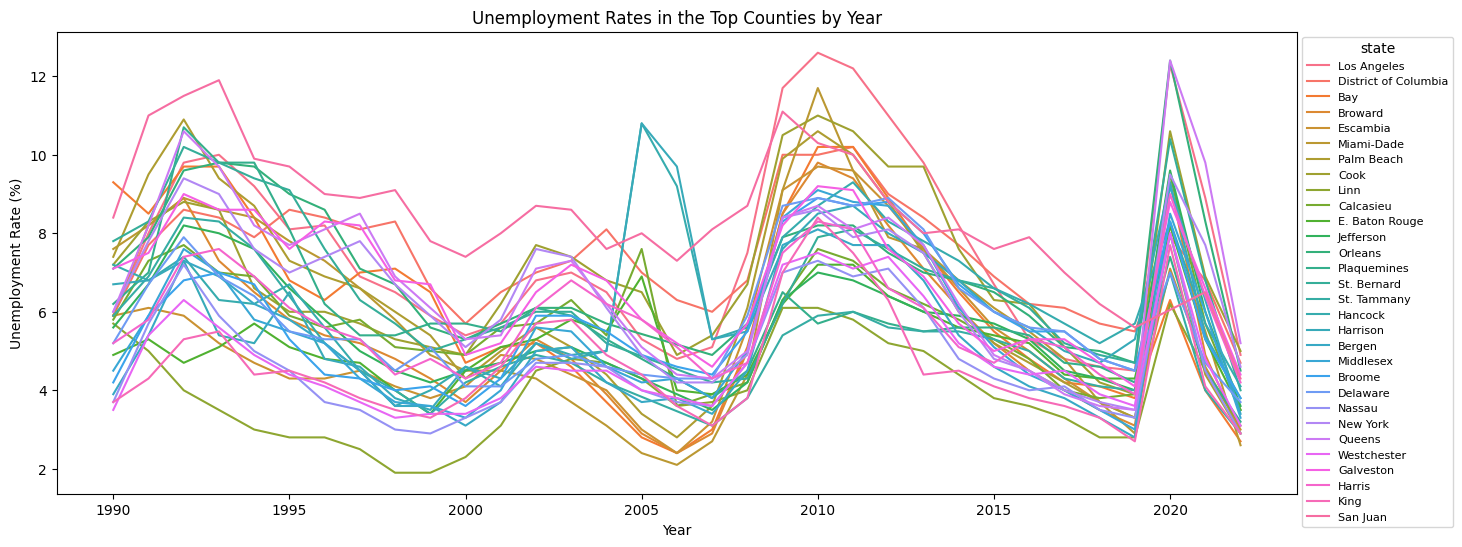

In [41]:
# Let's look at the counties that show up in top_df and look at their unemployment rate and Labor Force
filtered_employment_df = employment_df[employment_df['fipsCode'].isin(top_df['fipsCode'])]
filtered_employment_df = filtered_employment_df.merge(right=top_df[['fipsCode', 'state', 'county']], on='fipsCode', how='inner')

plt.figure(figsize=(16, 6))
sns.lineplot(x="Year", y="Unemployment Rate", hue="county", data=filtered_employment_df)

plt.title("Unemployment Rates in the Top Counties by Year")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.legend(title="state", fontsize=8, bbox_to_anchor=(1, 1))
plt.show()

It seems that unemployment rate can vary pretty drastically between counties. For example, the unemployment rate in just these 17 counties varies between less than 4% and almost 8% in 1990. However, when looking at the overall trends over a long period of time, these rates seem to move according to the same overall rising and falling patterns.

### 3.3.2. Labor Force of Top Counties

Now let's look at the Labor Force for the same counties over the same time period.

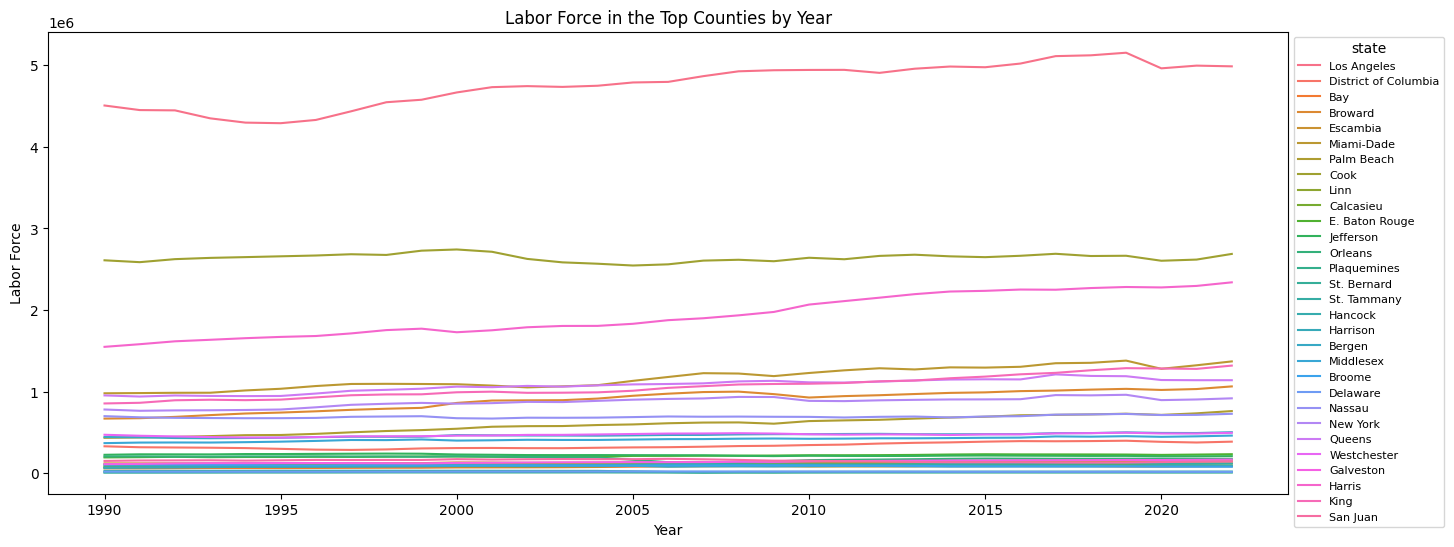

In [43]:
plt.figure(figsize=(16, 6))
sns.lineplot(x="Year", y="Labor Force", hue="county", data=filtered_employment_df)

plt.title("Labor Force in the Top Counties by Year")
plt.xlabel("Year")
plt.ylabel("Labor Force")
plt.legend(title="state", fontsize=8, bbox_to_anchor=(1, 1))
plt.show()

Labor force varies far less than unemployment rate over time. For every county, labor force seems to either follow a small but consistent positive trend, or stay fairly steady.

Counties also seem to generally maintain their rank relative to each other over time, which was not the case for unemployment.

Overall, high or low labor force does not seem to directly indicate a high or low unemployment rate for a county. So, while there very possibly could be some correlation between these two variables, we can conclude that they do tell us different pieces of information, and thus, we should be able to use both for our model.

# Part 4 : Combining the Datasets

In order to create a complete set of features, we need to combine our datasets. We want to extract important columns from the various datasets to ultimately find key features that determine the amount of money FEMA is going to spend on a project.

## 4.1. Merging Disaster and Assistance Data

Before combining the `disaster_df` and `assistance_df`, we need to remove the unnecessary columns that will not be used to predict `discounted_totalObligated`. This includes columns containing specific IDs associated with each project or row in the disaster dataset. These columns have no bearing on the amount of money that FEMA is going to spend on a project because they are arbitrary.

The two datasets can then be merged based on identifying columns. The specific disaster (`disasterNumber`) and specific county and state codes will be used to merge these two datasets.

In [ ]:
# drop columns
assistance_df_pared = assistance_df.drop(columns=['pwNumber', 'lastRefresh', 'hash', 'id'])
disaster_df_pared = disaster_df.drop(columns=['lastRefresh', 'hash', 'id', 'fyDeclared', 'declarationType', 'designatedArea', 'incidentEndDate'])

In [ ]:
# merge on disaster number, countyCode, and state
merged_df = assistance_df_pared.merge(disaster_df_pared, left_on = ['disasterNumber','countyCode', 'stateCode', 'stateNumberCode'], right_on = ['disasterNumber','fipsCountyCode', 'state', 'fipsStateCode'], suffixes=('_a', '_d'), how = 'inner')

### 4.1.1. Dropping Null and Duplicate Values

Now that we have combined the two main datasets from FEMA, we need to clean the new data frame by dropping null and duplicate values, renaming columns, and adding columns of interest based off of columns already in the dataframe.

In [ ]:
merged_df = merged_df.dropna() # drop null values just in case
merged_df = merged_df.drop_duplicates() # remove duplicates

In [ ]:
merged_df.head() # look at merged dataset

,disasterNumber,declarationDate_a,incidentType_a,applicationTitle,applicantId,damageCategoryCode,projectSize,county,countyCode,state_a,...,hmProgramDeclared,incidentBeginDate,tribalRequest,fipsStateCode,fipsCountyCode,placeCode,declarationRequestNumber,fipsCode_d,year_d,incidentDuration
0,1239,1998-08-26 00:00:00+00:00,Severe Storm,IMMEDIATE NEEDS FUNDING,465-19792-00,B - Protective Measures,Large,Val Verde,465.0,Texas,...,1,1998-08-22 00:00:00+00:00,0,48,465,99465,98062,48465,1998,9.0
1,1239,1998-08-26 00:00:00+00:00,Severe Storm,(L),465-19792-01,F - Public Utilities,Large,Val Verde,465.0,Texas,...,1,1998-08-22 00:00:00+00:00,0,48,465,99465,98062,48465,1998,9.0
2,1239,1998-08-26 00:00:00+00:00,Severe Storm,L,465-99465-00,C - Roads and Bridges,Large,Val Verde,465.0,Texas,...,1,1998-08-22 00:00:00+00:00,0,48,465,99465,98062,48465,1998,9.0
3,1239,1998-08-26 00:00:00+00:00,Severe Storm,Not Provided,465-062A0-00,C - Roads and Bridges,Small,Val Verde,465.0,Texas,...,1,1998-08-22 00:00:00+00:00,0,48,465,99465,98062,48465,1998,9.0
4,1239,1998-08-26 00:00:00+00:00,Severe Storm,Not Provided,465-19792-02,G - Recreational or Other,Small,Val Verde,465.0,Texas,...,1,1998-08-22 00:00:00+00:00,0,48,465,99465,98062,48465,1998,9.0


### 4.1.2. Creating Clean Columns

Merging the data created a lot of duplicate columns as well, so we need to drop those columns and continue cleaning the dataset.

We also want to pull the specific year and month each row in the dataset for merging later as well as checking for predictive power.

In [ ]:
# drop duplicated columns
merged_clean_df = merged_df.drop(["state_d", "declarationDate_d", "incidentType_d", "year_a", "year_d", "fipsCode_d"], axis=1)

# drop unnecessary columns
unnecessary_columns = ["applicationTitle", "applicantId", "femaDeclarationString", "obligatedDate", "dcc", "damageCategoryCode", "placeCode", "declarationRequestNumber"]
merged_clean_df = merged_clean_df.drop(unnecessary_columns, axis=1)

In [ ]:
# drop and rename duplicated columns
merged_clean_df.rename(columns={"state_a": "state", "declarationDate_a": "declarationDate", "incidentType_a": "incidentType", "fipsCode_a": "fipsCode"}, inplace=True)

# create year and month columns
merged_clean_df["year"] = merged_clean_df["incidentBeginDate"].dt.year
merged_clean_df["month"] = merged_clean_df["incidentBeginDate"].dt.month

### 4.1.3. Grouping States by Region

In order to prevent our model from having too many features, we want to find a way to create broader groups for predictive categories. Since we know there are different types and amounts of disasters that occur in different locations, one logical way to reduce our features is to group the US by region. These regions are recognized by FEMA: West, Midwest, South, and Northeast. Because our dataset also includes US territories, we have added a region label for that as well.

In [ ]:
# create lists for each region to categorize states
westStates = ['AK', 'HI', 'WA', 'OR', 'CA', 'MT', 'ID', 'WY', 'NV', 'UT', 'AZ', 'CO', 'NM']
midwestStates = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']
southStates = ['OK', 'TX', 'AR', 'LA', 'KY', 'TN', 'MS', 'AL', 'GA', 'SC', 'NC', 'VA', 'WV', 'MD', 'FL', 'DC', 'DE']
northeastStates = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
territoryOther = ['MP', 'GU', 'AS', 'VI', 'PR']

In [ ]:
conditions = [
    np.isin(merged_clean_df['stateCode'], westStates),
    np.isin(merged_clean_df['stateCode'], midwestStates),
    np.isin(merged_clean_df['stateCode'], southStates),
    np.isin(merged_clean_df['stateCode'], northeastStates),
    np.isin(merged_clean_df['stateCode'], territoryOther)
]
labels = ['West', 'Midwest', 'South', 'Northeast', 'TerritoryOther']
merged_clean_df['region'] = np.select(conditions, labels)

### 4.1.4. Creating Binary Variables

Since `projectSize` is only contains two categories, we can change it into a binary variable called `isLargeProject` and remove the original column.

There are also various programs that FEMA kept track of for each disaster. If one of the programs was envoked, a 1 is indicated in that column. To treat these as binary variables, we need to convert them to int type.

In [ ]:
# changing project size to binary variable
merged_clean_df['isLargeProject'] = np.where(merged_clean_df['projectSize'] == 'Small', 0, 1)

# drop projectSize column
merged_clean_df = merged_clean_df.drop(columns = ['projectSize'])

In [ ]:
# convert programDeclared columns into int type
boolean_columns = ["ihProgramDeclared", "iaProgramDeclared", "paProgramDeclared", "hmProgramDeclared", "tribalRequest"]

for column in boolean_columns:
  merged_clean_df[column] = merged_clean_df[column].astype(int)

## 4.2. Merging the New Dataframe with Employemnt Data

In order to account for varying populations and economic standings of each area affected by a disaster, we need to add another dataframe to our combined disaster dataset, `employment_df`. The employment data contains information on labor force and unemployment rates which we want to include in our model.

To merge in this data, we need to combine them based on `year` and `fipsCode`. We will simultaneously extract only the columns we need from the `employment_df` dataframe.

In [ ]:
# rename Year to year
employment_df = employment_df.rename(columns={"Year": "year"})

# merge on year and fipsCode
fema_df = pd.merge(merged_clean_df, employment_df[['year', 'Labor Force', 'Unemployment Rate', 'fipsCode']], on=["year", "fipsCode"])

Finally we want to clean our dataset, to only include the columns we are considering for our final model. In this step, we remove some of columns we used to create new columns and the ones we used for merging but no longer need.

In [ ]:
# create list of columns to drop
drop_col = ['disasterNumber', 'declarationDate', 'county', 'countyCode', 'state',
            'stateCode', 'stateNumberCode', 'projectAmount', 'federalShareObligated',
            'cpi', 'totalObligated', 'discounted_projectAmount', 'discounted_federalShareObligated',
            'declarationTitle', 'incidentBeginDate', 'fipsStateCode', 'fipsCountyCode', 'fipsCode', 'year']
fema_df = fema_df.drop(columns = drop_col)

In [ ]:
# rename new columns for consistency
fema_df = fema_df.rename(columns={"Labor Force": "laborForce", "Unemployment Rate": "unemploymentRate"})

In [ ]:
fema_df.head() # display first 5 rows of final mergedc dataset

,incidentType,damageCategory,month,discounted_totalObligated,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,tribalRequest,incidentDuration,region,isLargeProject,laborForce,unemploymentRate
0,Severe Storm,Protective Measures,8,79651.65,0,1,1,1,0,9.0,South,1,17916,9.7
1,Severe Storm,Public Utilities,8,330317.13,0,1,1,1,0,9.0,South,1,17916,9.7
2,Severe Storm,Roads and Bridges,8,53512.56,0,1,1,1,0,9.0,South,1,17916,9.7
3,Severe Storm,Roads and Bridges,8,17593.81,0,1,1,1,0,9.0,South,0,17916,9.7
4,Severe Storm,Recreational or Other,8,15328.53,0,1,1,1,0,9.0,South,0,17916,9.7


### **CHECKPOINT**

We used this checkpoint to save the merged dataset as a CSV, so it can be loaded in later without re-running all the prior code.

In [ ]:
# save as CSV
fema_df.to_csv('/content/drive/Shareddrives/CIS 5450 Project/datasets/fema.csv', index=False)

In [44]:
# loading the CSV
fema_df = pd.read_csv('/content/drive/Shareddrives/CIS 5450 Project/datasets/fema.csv')

# Part 5 : Feature Engineering

In order to make predictions from categorical data, we need to one-hot encode these variables. Let's first look at the various categorical variables in our dataset and identify how many categories each one contains

## 5.1. One-hot Encoding

In [45]:
# check unique values in categorical columns
categorical_columns = ["incidentType", "damageCategory", "month", "region"]
unique_list = []

for column in categorical_columns:
  nunique = fema_df[column].nunique()
  values = dict(fema_df[column].value_counts().items())
  unique_list.append({"column": column, "count": nunique, "value": values})

pd.options.display.max_colwidth = 1000
unique_df = pd.DataFrame(unique_list)
unique_df

,column,count,value
0,incidentType,19,"{'Severe Storm': 280310, 'Hurricane': 174193, 'Flood': 72286, 'Biological': 38079, 'Snowstorm': 32520, 'Severe Ice Storm': 21175, 'Fire': 6979, 'Tornado': 5209, 'Earthquake': 2717, 'Coastal Storm': 2547, 'Other': 901, 'Dam/Levee Break': 174, 'Freezing': 172, 'Tsunami': 125, 'Mud/Landslide': 114, 'Winter Storm': 87, 'Terrorist': 84, 'Volcanic Eruption': 52, 'Chemical': 41}"
1,damageCategory,8,"{'Roads and Bridges': 219128, 'Protective Measures': 192592, 'Debris Removal': 71333, 'Public Buildings': 68560, 'Recreational or Other': 34445, 'Public Utilities': 29741, 'State Management': 11018, 'Water Control Facilities': 10948}"
2,month,12,"{9: 110040, 8: 74746, 1: 72344, 4: 58860, 3: 55907, 5: 52200, 6: 49558, 12: 48201, 10: 47623, 2: 38413, 7: 20690, 11: 9183}"
3,region,5,"{'South': 259404, 'Midwest': 165316, 'Northeast': 154906, 'West': 43438, 'TerritoryOther': 14701}"


In [46]:
# one hot encode categorical columns excluding declarationTitle
fema_onehot_df = pd.get_dummies(fema_df, columns = ["incidentType", "damageCategory", "month", "region"])

In [47]:
# create a function to cast text into camel case
def to_camel_case(text):
  words = text.split()
  return words[0].lower() + ''.join(word.capitalize() for word in words[1:])

# create a dictionary to rename months
month_dict = {1: "january", 2: "february", 3: "march", 4: "april", 5: "may", 6: "june", 7: "july", 8: "august", 9: "september", 10: "october", 11: "november", 12: "december"}

# create a dictionary to rename columns
columns = fema_onehot_df.columns
rename_dict = {"disasterNumber": "disasterCount"}

for column in columns:
  if "incidentType" in column:
    split_column = column.split("_")
    rename_dict[column] = to_camel_case(split_column[1] + " Disaster")
  elif "damageCategory" in column:
    split_column = column.split("_")
    rename_dict[column] = to_camel_case(split_column[1] + " Damage")
  elif "month" in column:
    split_column = column.split("_")
    rename_dict[column] = month_dict[int(split_column[1])]
  elif "year" in column:
    split_column = column.split("_")
    rename_dict[column] = split_column[1]
  elif "region" in column:
    split_column = column.split("_")
    rename_dict[column] = to_camel_case(split_column[1] + " Region")

# rename columns
fema_clean_df = fema_onehot_df.rename(columns=rename_dict)


In [ ]:
fema_clean_df.head()

,discounted_totalObligated,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,tribalRequest,incidentDuration,isLargeProject,laborForce,unemploymentRate,...,august,september,october,november,december,midwestRegion,northeastRegion,southRegion,territoryotherRegion,westRegion
0,79651.65,0,1,1,1,0,9.0,1,17916,9.7,...,1,0,0,0,0,0,0,1,0,0
1,330317.13,0,1,1,1,0,9.0,1,17916,9.7,...,1,0,0,0,0,0,0,1,0,0
2,53512.56,0,1,1,1,0,9.0,1,17916,9.7,...,1,0,0,0,0,0,0,1,0,0
3,17593.81,0,1,1,1,0,9.0,0,17916,9.7,...,1,0,0,0,0,0,0,1,0,0
4,15328.53,0,1,1,1,0,9.0,0,17916,9.7,...,1,0,0,0,0,0,0,1,0,0


Now we can create appropriate models from the values in each of these columns.

## 5.2. Feature Correlation Maps

We will start by looking at various correlation maps to learn which features are most correlated with each other. Since we have over 50 feature columns, we will divide this into sections.

### 5.2.1. Correlation of Incident Types

In [ ]:
# create dataframe to compute correlation of disasters
disaster_columns = []

for column in fema_clean_df.columns:
  if "Disaster" in column:
    disaster_columns.append(column)

corr_disaster_df = fema_clean_df[disaster_columns]

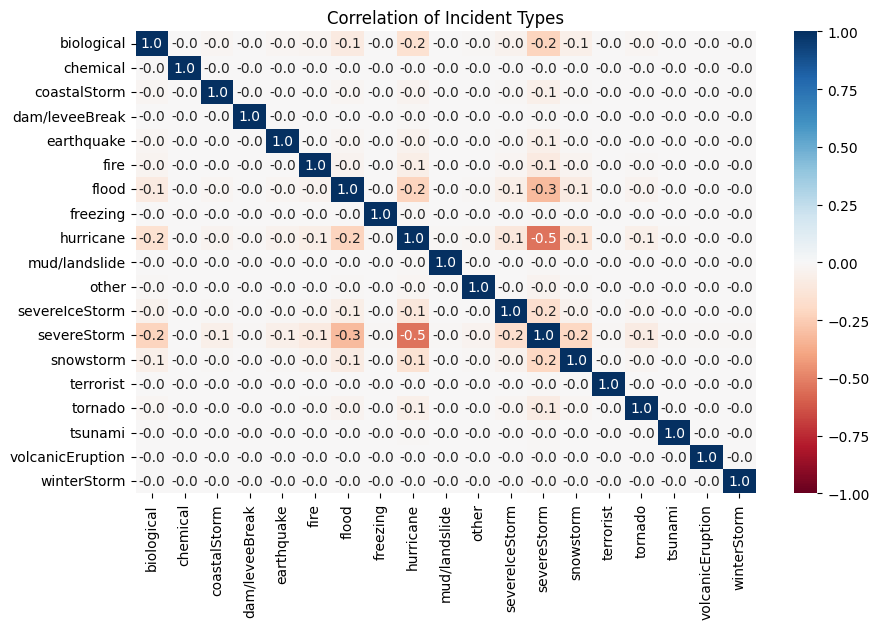

In [ ]:
# plot correlation of incident types
plt.figure(figsize=(10, 6))
fig = sns.heatmap(data=corr_disaster_df.corr(), cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt=".1f")

plt.title("Correlation of Incident Types")
ticks = [col[:-8] for col in disaster_columns]
fig.set_xticklabels(ticks)
fig.set_yticklabels(ticks)
plt.show()

The most correlated incident types seem to be associated with severe storms. This map shows us that severe storms have some sort of association with biological, flooding, and hurricane disasters. However, the majority of these features have no correlation with values of 0.0, and the ones with correlation are no higher than 0.5 in magnitude.

### 5.2.2. Correlation of Damage Categories

In [ ]:
# create dataframe to compute correlation of damages
damage_columns = []

for column in fema_clean_df.columns:
  if "Damage" in column:
    damage_columns.append(column)

corr_damage_df = fema_clean_df[damage_columns]

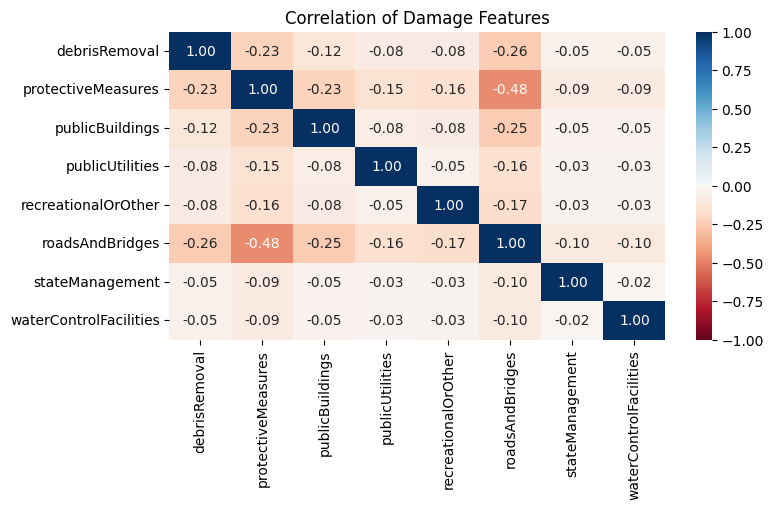

In [ ]:
# plot correlation of damages
plt.figure(figsize=(8, 4))
fig = sns.heatmap(data=corr_damage_df.corr(), cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt=".2f")

plt.title("Correlation of Damage Features")
ticks = [col[:-6] for col in damage_columns]
fig.set_xticklabels(ticks)
fig.set_yticklabels(ticks)
plt.show()

While many of the damage features have some indication of correlation (mainly in the protective measures and roads and bridges categories), again, none of these correlation values exceed 0.5.

### 5.2.3. Correlation of Assistance and Project Type

In [ ]:
# create dataframe to compute correlation of project and work force features
project_columns = ["laborForce", "unemploymentRate"]

for column in fema_clean_df.columns:
  if "ProgramDeclared" in column or "Project" in column:
    project_columns.append(column)

corr_project_df = fema_clean_df[project_columns]

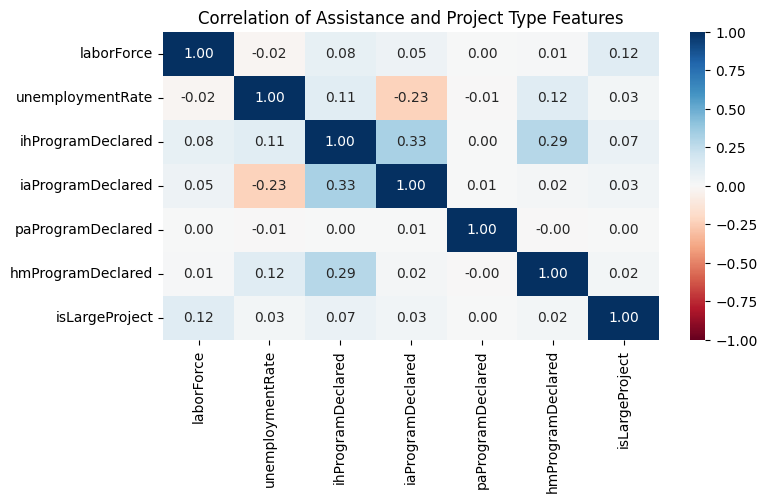

In [ ]:
# plot correlation of assistance and project type
plt.figure(figsize=(8, 4))
fig = sns.heatmap(data=corr_project_df.corr(), cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt=".2f")

plt.title("Correlation of Assistance and Project Type Features")
plt.show()

Finally, when comparing the last set of features, there is no correlation among features that exceeds 0.33 which shows that the slight correlation between programs like the IA and IH programs is not very high.

## 5.3. Principal Component Analysis (PCA)

Since we still have many columns as inputs for our model, one way to reduce the dimensionality of our data is to use PCA.

### 5.3.1. Splitting Data into Train and Test

In [ ]:
# create features and target dataframes
features = fema_clean_df.drop("discounted_totalObligated", axis=1)
target = fema_clean_df["discounted_totalObligated"]

In [ ]:
# conduct 80/20 train-test split
seed = 0
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = seed)

### 5.3.2. Computing Principal Component Analysis

In [ ]:
# address scale-invariance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# initiate and fit PCA
pca = PCA()
pca_data = pca.fit(X_train_scaled)

In [ ]:
# compute cumulative explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)
cum_dummy_evr = np.insert(cum_evr, 0, 0) # dummy variable so the number of components starts at 1

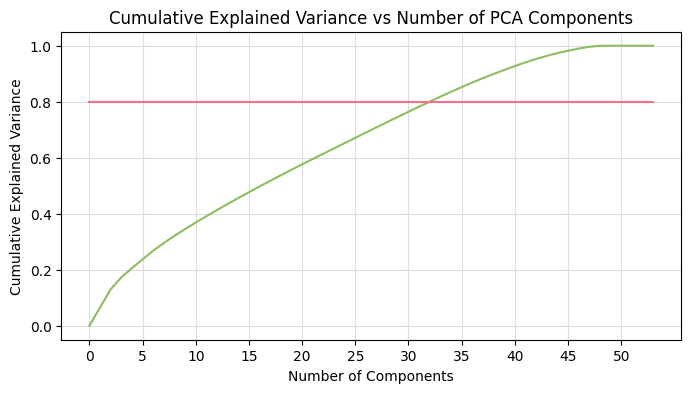

In [ ]:
# plot explained variance ratios
x_ticks = np.arange(len(cum_dummy_evr))

plt.figure(figsize=(8, 4))
sns.lineplot(x=x_ticks, y=cum_dummy_evr, color="#8dbd61")
sns.lineplot(x=x_ticks, y=0.8 * np.ones(len(cum_dummy_evr)), color="#f66f8d")

plt.title("Cumulative Explained Variance vs Number of PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.xticks(np.arange(0, len(cum_dummy_evr), 5))
plt.grid(color="#dddddd")

plt.show()

Here we see that PCA was able to reduce the dimensionality of our data to 32 components which is a little over half of our original number of features.

In [ ]:
# refit PCA with 32 components
pca = PCA(n_components=32)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Part 6 : Regression Modeling

Now, our dataset has been meticulously prepared for subsequent modeling. Our primary objective is to predict the `discounted_totalObligated`, a continuous variable, necessitating the application of regression models.

Prior to supervised learning, we propose an unsupervised learning model. The idea behind this approach is to explore the possibility of effectively clustering our dataset and then applying the regression model to each distinct cluster. Subsequently, we will undertake several regression models to predict the target variable and scrutinize the outcomes.

## 6.1. Unsupervised Learning

In order to cluster our dataset, we have chosen to implement a K-Means clustering model. Given the vulnerability of this model to scale variations, we intend to standardize both our train and test datasets prior to its application. Subsequently, we will construct an elbow plot for varying numbers of clusters (k) to observe the convergence of the sum of squared distances (WCSS). This analysis will guide the determination of an appropriate number of clusters for subsequent clustering.

In [48]:
# standardize whole dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(fema_clean_df)

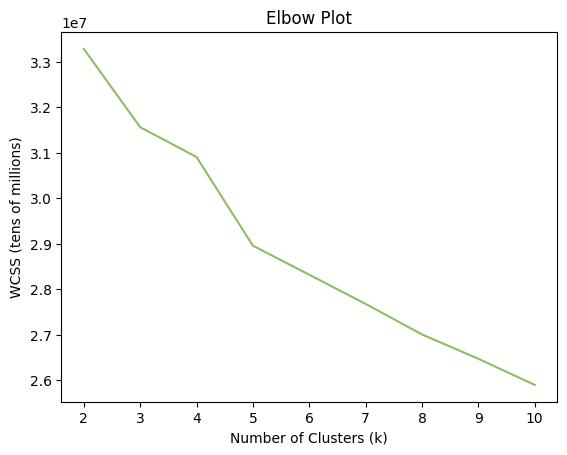

In [49]:
# generate an elbow plot
distortion_df = pd.DataFrame(columns=["k", "distortion"])

for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
  kmeans.fit(data_scaled) # use scaled data to interpret results

  new_distortion = pd.DataFrame({"k": [k], "distortion": [kmeans.inertia_]})
  distortion_df = pd.concat([distortion_df, new_distortion], ignore_index=True)

sns.lineplot(distortion_df, x="k", y="distortion", color="#8dbd61")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (tens of millions)")
plt.title("Elbow Plot")

plt.show()

Based on the analysis of the aforementioned elbow plot, it appears that partitioning the data into five groups is deemed appropriate. Subsequently, we will reapply the K-Means clustering algorithm using this identified optimal number of clusters and proceed to examine the statistical attributes within each cluster.

In [ ]:
# refit KMeans on PCA data with 5 clusters
kmeans = KMeans(n_clusters=5, n_init="auto", random_state=0)
kmeans = kmeans.fit(data_scaled)

In [ ]:
# create dataframe with scaled data
kmeans_df = pd.DataFrame(data_scaled)
kmeans_df.columns = fema_clean_df.columns
kmeans_df.index = fema_clean_df.index

# add cluster values to the dataframe
clusters = kmeans.labels_.tolist()
kmeans_df["cluster"] = clusters

In [ ]:
# show scaled data with clusters
kmeans_df.head()

,discounted_totalObligated,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,tribalRequest,incidentDuration,isLargeProject,laborForce,unemploymentRate,...,september,october,november,december,midwestRegion,northeastRegion,southRegion,territoryotherRegion,westRegion,cluster
0,-0.006854,-1.054465,1.490439,0.020618,0.281016,-0.006507,-0.320372,2.498050,-0.377031,1.241365,...,-0.456637,-0.284073,-0.120868,-0.285932,-0.591534,-0.566401,1.207716,-0.153606,-0.270347,2
1,0.065699,-1.054465,1.490439,0.020618,0.281016,-0.006507,-0.320372,2.498050,-0.377031,1.241365,...,-0.456637,-0.284073,-0.120868,-0.285932,-0.591534,-0.566401,1.207716,-0.153606,-0.270347,2
2,-0.014420,-1.054465,1.490439,0.020618,0.281016,-0.006507,-0.320372,2.498050,-0.377031,1.241365,...,-0.456637,-0.284073,-0.120868,-0.285932,-0.591534,-0.566401,1.207716,-0.153606,-0.270347,1
3,-0.024816,-1.054465,1.490439,0.020618,0.281016,-0.006507,-0.320372,-0.400312,-0.377031,1.241365,...,-0.456637,-0.284073,-0.120868,-0.285932,-0.591534,-0.566401,1.207716,-0.153606,-0.270347,1
4,-0.025472,-1.054465,1.490439,0.020618,0.281016,-0.006507,-0.320372,-0.400312,-0.377031,1.241365,...,-0.456637,-0.284073,-0.120868,-0.285932,-0.591534,-0.566401,1.207716,-0.153606,-0.270347,2


In [ ]:
# compute the statistics for each cluster
cluster_stats_df = kmeans_df.groupby("cluster").mean()
cluster_stats_df

,discounted_totalObligated,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,tribalRequest,incidentDuration,isLargeProject,laborForce,unemploymentRate,...,august,september,october,november,december,midwestRegion,northeastRegion,southRegion,territoryotherRegion,westRegion
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.014103,-0.770738,-0.297455,0.017200,-0.918461,-0.006507,-0.293835,0.036444,0.338260,-0.080651,...,-0.304698,-0.398177,-0.190276,0.298474,1.111611,-0.143249,0.078132,-0.374233,-0.128055,0.922130
1,-0.022237,-0.183625,-0.017087,-0.005785,0.136192,-0.006507,-0.223329,-0.149594,-0.272691,-0.048357,...,-0.234222,-0.309598,-0.120324,-0.010120,-0.150529,0.434011,-0.117279,-0.175266,-0.086469,-0.162030
2,0.023149,0.521208,0.312610,0.020618,0.204840,-0.006507,-0.269966,0.224260,0.207739,0.059200,...,0.626481,0.818670,0.362006,-0.115828,-0.285932,-0.585447,0.000590,0.581078,0.243941,-0.261005
3,-0.013753,-0.206662,0.290870,-0.147052,0.161606,-0.006507,-0.305827,-0.048658,-0.197563,-0.151986,...,-0.359587,-0.404814,-0.284073,-0.029012,0.084478,0.410396,-0.412849,0.172462,-0.153606,-0.255869
4,0.103488,0.943405,-0.670943,-0.080047,0.264580,0.102471,3.942872,0.008803,0.315342,0.328392,...,-0.364361,-0.456637,-0.284073,-0.120868,-0.285932,-0.286673,0.794889,-0.506444,-0.153606,0.224576


In the table presented above, we can observe the average values of each column within every cluster.

However, dividing our dataset into 5 groups may pose difficulties in applying a supervised model to each group due to insufficient data. Moreover, even after setting k=5, the graph exhibits a steep decrease, making it challenging to definitively assert that 5 is the most appropriate number of clusters. Given these considerations, we have concluded to proceed with our supervised learning without employing clustering.

## 6.2. Supervised Learning

We are currently advancing to the supervised learning stage, specifically with non-clustered data. As previously highlighted, our principal objective is to predict the `discounted_totalObligated` value.

Our chosen approach involves utilizing Linear Regression as a foundational model, followed by an investigation into Lasso Regression to evaluate its potential in improving the quality of predictions.

### 6.2.1. Linear Regression

In [ ]:
# initialize model and fit it on the training set
lin_reg = LinearRegression()
lin_reg.fit(X_train_pca, y_train)

# predict on the test set
y_pred = lin_reg.predict(X_test_pca)

# compute the R-squared score and MSE
lin_reg_score_train = lin_reg.score(X_train_pca, y_train)
lin_reg_score_test = lin_reg.score(X_test_pca, y_test)
lin_reg_mse = mean_squared_error(y_test, y_pred)

print("< Linear Regression >\n")
print(f"Train R-squared score: {lin_reg_score_train:.4f}")
print(f"Test R-squared score: {lin_reg_score_test:.4f}")
print(f"MSE: {lin_reg_mse}")

< Linear Regression >

Train R-squared score: 0.0033
Test R-squared score: 0.0030
MSE: 10274042825122.95


The linear regression model seems to perform poorly with our dataset, as indicated by the low R-squared scores (0.0023) and high MSE. This suggests that a simple linear relationship between the independent and dependent variables may not adequately capture the underlying patterns in the data.


### 6.2.2. Lasso Regression

Given the underperformance of the linear regression model, it may be beneficial to explore more complex models that can handle feature selection and regularization. Lasso Regression, which includes a regularization term that penalizes the absolute values of the regression coefficients, can be a suitable option.

In [ ]:
# initialize model and fit it on the training set
lasso_reg = Lasso(alpha=0.5)
lasso_reg.fit(X_train_pca, y_train)

# predict on the test set
y_pred = lasso_reg.predict(X_test_pca)

# rind the R-squared score
lasso_reg_score_train = lasso_reg.score(X_train_pca, y_train)
lasso_reg_score_test = lasso_reg.score(X_test_pca, y_test)
lasso_reg_mse = mean_squared_error(y_test, y_pred)

print("< Lasso Regression >\n")
print(f"Train R-squared score: {lasso_reg_score_train:.4f}")
print(f"Test R-squared score: {lasso_reg_score_test:.4f}")
print(f"MSE: {lasso_reg_mse}")

< Lasso Regression >

Train R-squared score: 0.0033
Test R-squared score: 0.0030
MSE: 10274042721343.121


Unfortunately, the Lasso Regression model does not seem to provide a significant improvement over the linear regression model. The performance of the model, including R-squared scores (0.0038) and MSE, remain low, indicating that the model is not capturing the underlying patterns in the data effectively.

# Part 7 : Classification Modeling

Considering the limitations of both linear regression and Lasso Regression in predicting a continuous target variable, we have concluded that transforming the continuous target variable into a categorical one and exploring classification models could be a promising avenue for improving model performance and practical applicability.

Our objective remains focused on predicting the `discounted_totalObligated` as the target value. However, we have decided to introduce a new classification scheme with five labels: Very Low, Low, Medium, High, and Very High, based on this column. Subsequently, we will explore various classification models to identify the one that most effectively represents the distribution of our datasets.



### 7.1. Creating Lables

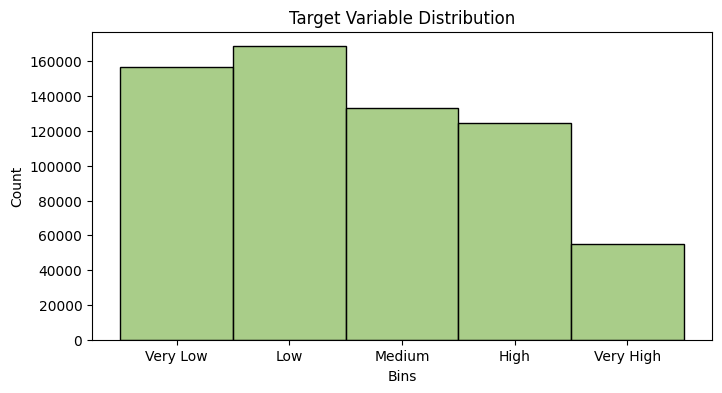

In [ ]:
# build a function to classify the target variable
def classify(x):
  if(x < 2500):
    return 'Very Low'
  elif(x < 7500):
    return 'Low'
  elif(x < 20000):
    return 'Medium'
  elif(x < 100000):
    return 'High'
  else:
    return 'Very High'

# classify the target variable and drop the original column
fema_data = fema_clean_df.sort_values('discounted_totalObligated')
fema_data['bin'] = fema_data['discounted_totalObligated'].apply(lambda x: classify(x))
fema_data = fema_data.drop('discounted_totalObligated', axis=1)

# create histogram of bins
plt.figure(figsize=(8, 4))
sns.histplot(data=fema_data, x='bin', color="#8dbd61")

plt.title("Target Variable Distribution")
plt.xlabel("Bins")
plt.show()

The `discounted_totalObligated` column exhibits a slightly skewed distribution. In lieu of precisely dividing the data into five bins with each representing 20% of the entire dataset, we opted to manually propose criteria. We took into consideration both the practical meaning of these boundaries and the need for balance among the bins. While most of the classes are fairly evenly distributed, the "very high" bin contains many expensive outliers so it is okay that it is less populated than the other bins.

In [ ]:
fema_data['bin'].unique()

array(['Very Low', 'Low', 'Medium', 'High', 'Very High'], dtype=object)

In [ ]:
# create features and target dataframes
features = fema_data.drop('bin', axis=1)
labels = fema_data['bin']

In [ ]:
# conduct 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 0, test_size = 0.2)

## 7.2. Trying Different Models

We are now prepared to experiment with various classification models using our newly defined labels. Our initial choice for the foundational model is the Decision Tree Classifier. Subsequently, we plan to explore more advanced models, including the Random Forest Classifier and AdaBoost Classifier. Finally, we intend to employ a Neural Network model in our analysis.

### 7.2.1. Decision Tree Classifier

In [ ]:
# initialize model and fit it on the training set
dt = DecisionTreeClassifier(random_state = 0, max_depth = 12)
dt.fit(X_train, y_train)

# predict on testing sets
y_pred_dt = dt.predict(X_test)

# compute the accuracy
dt_score_train = dt.score(X_train, y_train)
dt_score_test = dt.score(X_test, y_test)

print("< Decision Tree Classifier >\n")
print(f"Train Accuracy: {dt_score_train:.4f}")
print(f"Test Accuracy: {dt_score_test:.4f}")

< Decision Tree Classifier >

Train Accuracy: 0.4112
Test Accuracy: 0.4012


Considering that the previous R-squared scores in regression were less than 1%, it is evident that our classification model excels with categorical labels, demonstrating a significant improvement over the previous regression models.

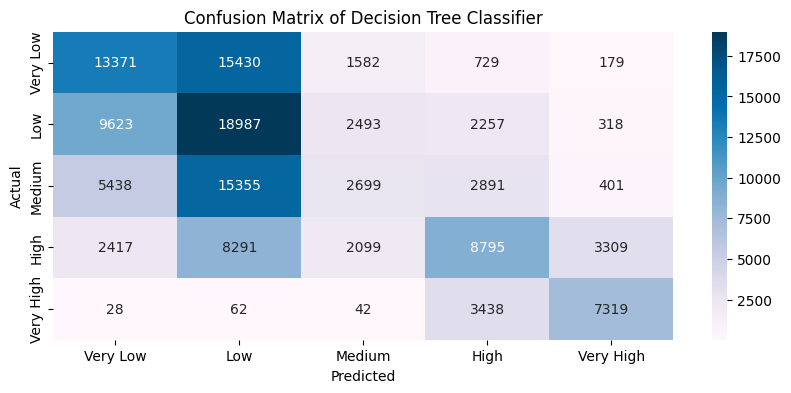

In [ ]:
# visualize a confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=fema_data['bin'].unique())

plt.figure(figsize=(10, 4))
sns.heatmap(cm_dt, annot=True, fmt="g", cmap="PuBu", xticklabels=fema_data['bin'].unique(), yticklabels=fema_data['bin'].unique())

plt.title("Confusion Matrix of Decision Tree Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

Looking at the confusion matrix, we can see that the decision tree is able to classify the outliers fairly well, but has trouble differentiating Low and Medium data points.

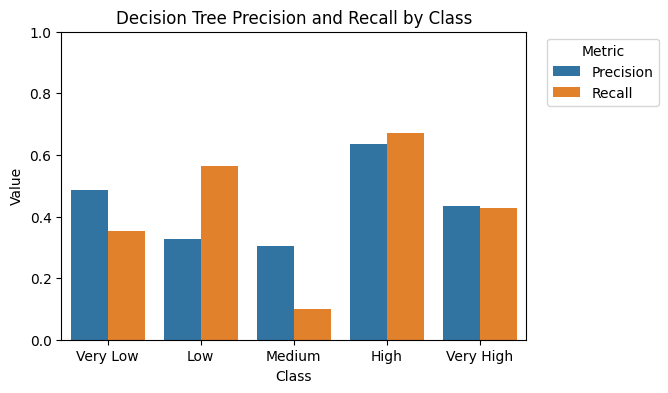

In [ ]:
# Show Precision and Recall
precision = precision_score(y_test, y_pred_dt, average=None)
recall = recall_score(y_test, y_pred_dt, average=None)

plot_df = pd.DataFrame({"Class" : fema_data['bin'].unique(), "Precision" : precision, "Recall" : recall})
plot_df = pd.melt(plot_df, 'Class')

plt.figure(figsize=(6, 4))
sns.barplot(data = plot_df, x = 'Class', y = 'value', hue='variable')
plt.title('Decision Tree Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend(title="Metric", fontsize=10, bbox_to_anchor=(1.3, 1))
plt.show()

As expected from the confusion matrix, Medium has both the lowest precision and the lowest recall. Notably, High contains both the highest precision and recall.

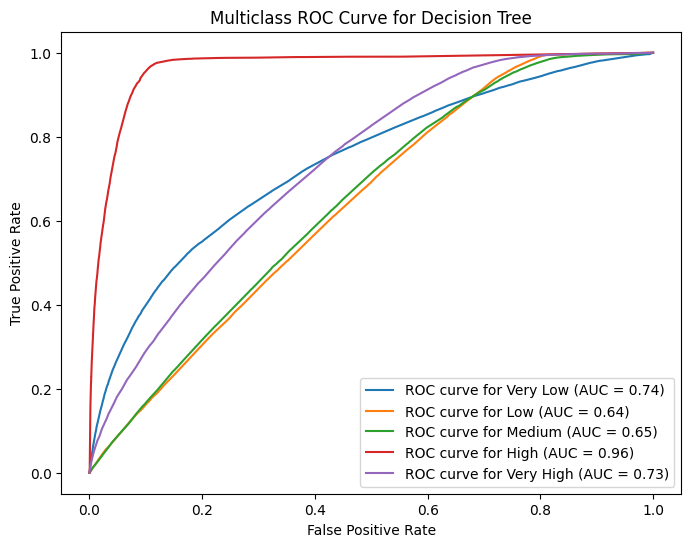

In [ ]:
#Multiclass ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))

label_binarizer = LabelBinarizer().fit(y_train)
y_binarizer = label_binarizer.transform(y_test)
y_score = dt.predict_proba(X_test)

for class_id, class_name in zip(range(len(fema_data['bin'].unique())), fema_data['bin'].unique()):
    RocCurveDisplay.from_predictions(
        y_binarizer[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_name}",
        ax=ax
    )

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for Decision Tree")
plt.legend()
plt.show()

Looking at the ROC curve, we can clearly see that our decision tree is very good at predicting High, ok at predicting Very Low and Very High, and very bad at predicting Medium and Low.

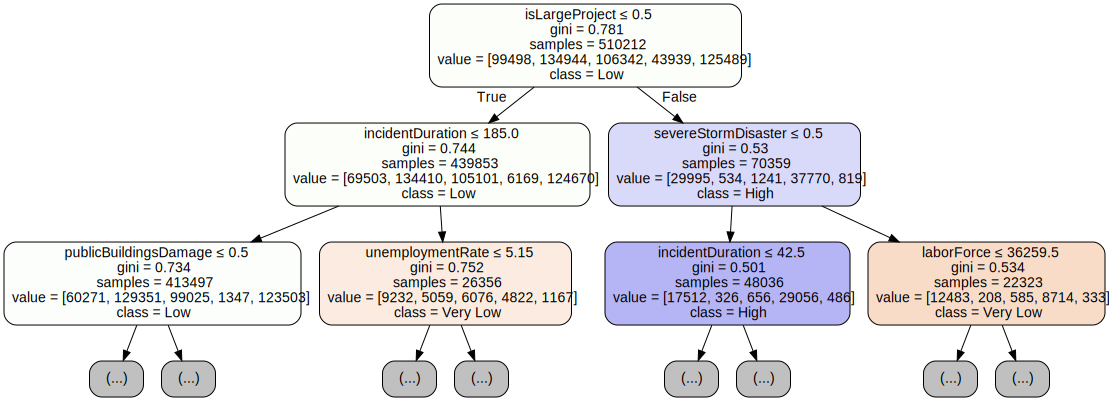

In [ ]:
# visualize decision tree
dot_data = export_graphviz(dt, out_file=None, feature_names=X_train.columns,
                           class_names=['Very Low', 'Low', 'Medium', 'High', 'Very High'], filled=True, rounded=True,
                           special_characters=True, max_depth=2)
graph = graphviz.Source(dot_data)

graph.render("decision_tree")
graph

* From the decision tree visualization, it is observed that the most crucial feature for distinguishing the expected amount of funds is whether it is a large project. Notably, in our original data (before one-hot encoding), the `projectSize` column represents an eligible amount set in the damage survey, making it a pertinent primary criterion.

* Additionally, our manually created column, `incidentDuration`, emerges as a second and third criteria in the decision tree. This underscores the significant impact of the duration of each disaster on the fund amount required for assistance. Therefore, it seems that recognizing and considering this aspect is crucial for predicting future expenditures more accurately.

* Furthermore, features related to employment, such as `unemploymentRate` and `laborForce`, appear to influence our outcome. Despite the apparent lack of a direct connection between the employment dataset and disaster & assistance dataset, it is evident that there exists a discernible relationship of influence between them.

### 7.2.2. Random Forest Classifier

While our Decision Tree classifier effectively captures the distribution of our datasets better than any other regression models attempted previously, there is still much room for improvement. To address this, we can explore an advanced ensemble model, Random Forest.

In [ ]:
# initialize model and fit it on the training set
forest = RandomForestClassifier(n_estimators=20, random_state=0, bootstrap=True)
forest.fit(X_train, y_train)

# predict on the test set
y_pred_forest = forest.predict(X_test)

# compute the accuracies
forest_score_train = forest.score(X_train, y_train)
forest_score_test = forest.score(X_test, y_test)

print("< Random Forest Classifier >\n")
print(f"Train Accuracy: {forest_score_train:.4f}")
print(f"Test Accuracy: {forest_score_test:.4f}")

< Random Forest Classifier >

Train Accuracy: 0.5517
Test Accuracy: 0.4257


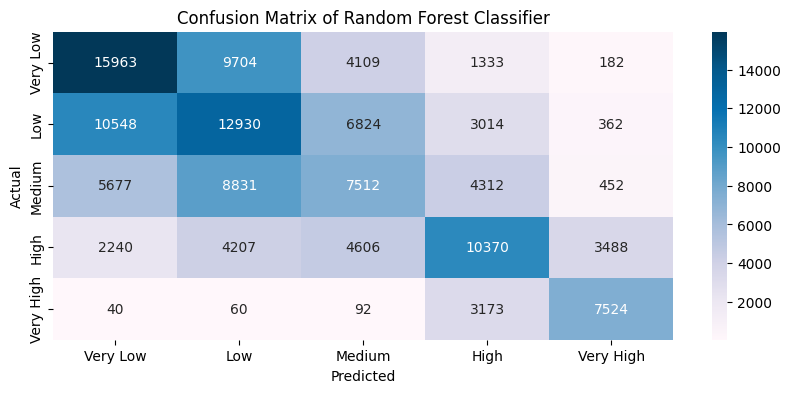

In [ ]:
# visualize a confusion matrix
cm_forest = confusion_matrix(y_test, y_pred_forest, labels=fema_data['bin'].unique())

plt.figure(figsize=(10, 4))
sns.heatmap(cm_forest, annot=True, fmt="g", cmap="PuBu", xticklabels=fema_data['bin'].unique(), yticklabels=fema_data['bin'].unique())

plt.title("Confusion Matrix of Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

Our Random Forest model demonstrates a slightly higher accuracy than the previous Decision Tree. However, in the confusion matrix, it markedly excels in predicting moderate and large amounts of expenditures, showcasing a significantly improved quality in those predictions. This indicates that the Random Forest model exhibits superior quality across all labels, achieving a better balance in performance.

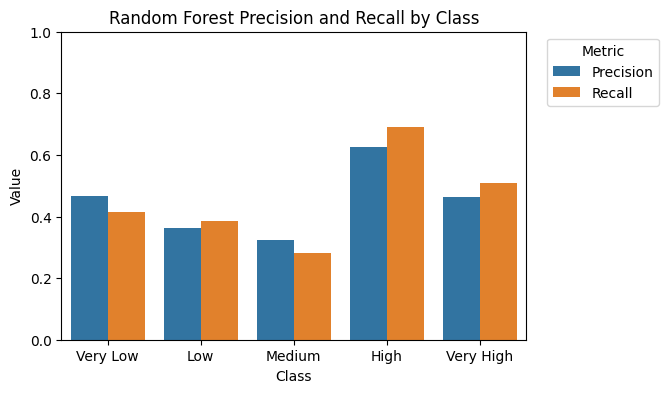

In [ ]:
# Show Precision and Recall
precision = precision_score(y_test, y_pred_forest, average=None)
recall = recall_score(y_test, y_pred_forest, average=None)

plot_df = pd.DataFrame({"Class" : fema_data['bin'].unique(), "Precision" : precision, "Recall" : recall})
plot_df = pd.melt(plot_df, 'Class')

plt.figure(figsize=(6, 4))
sns.barplot(data = plot_df, x = 'Class', y = 'value', hue='variable')
plt.title('Random Forest Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend(title="Metric", fontsize=10, bbox_to_anchor=(1.3, 1))
plt.show()

Compared to the Decision Tree precision and recall chart, the most prominent changes are improvements in the Medium class while the recall of the Low class was decreased. Otherwise, there seems to be small improvements in the other classes.

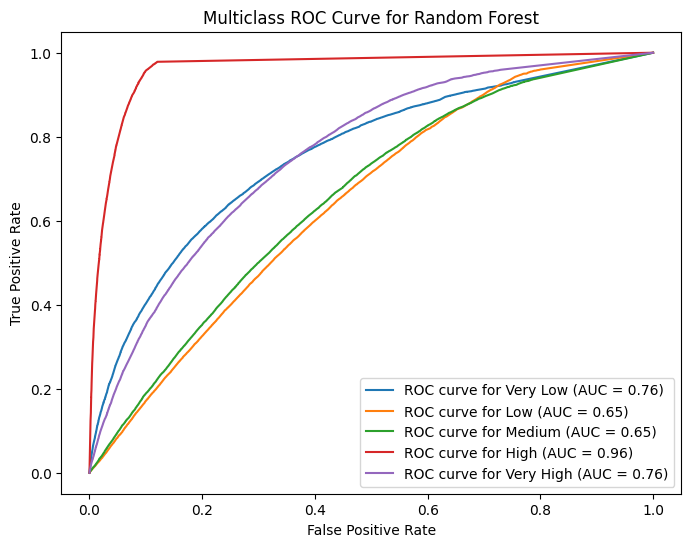

In [ ]:
#Multiclass ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))

y_score = forest.predict_proba(X_test)

for class_id, class_name in zip(range(len(fema_data['bin'].unique())), fema_data['bin'].unique()):
    RocCurveDisplay.from_predictions(
        y_binarizer[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_name}",
        ax=ax
    )

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for Random Forest")
plt.legend()
plt.show()

Compared to the Decision Tree ROC curve, we can see a sharper increase in the quality of the Very Low and Very High classes.

### 7.2.3. AdaBoost Classifier

Given the slight imbalance in our class distributions, we have opted to incorporate AdaBoost into our model selection. AdaBoost is particularly effective in handling class imbalance, making it a suitable choice for our analysis.

In [ ]:
# initialize model and fit it on the training set
ada = AdaBoostClassifier(random_state=0)
ada.fit(X_train, y_train)

# predict on the test set
y_pred_ada = ada.predict(X_test)

# compute the accuracies
ada_score_train = ada.score(X_train, y_train)
ada_score_test = ada.score(X_test, y_test)

print("< AdaBoost Classifier >\n")
print(f"Train Accuracy: {ada_score_train:.4f}")
print(f"Test Accuracy: {ada_score_test:.4f}")

< AdaBoost Classifier >

Train Accuracy: 0.3675
Test Accuracy: 0.3651


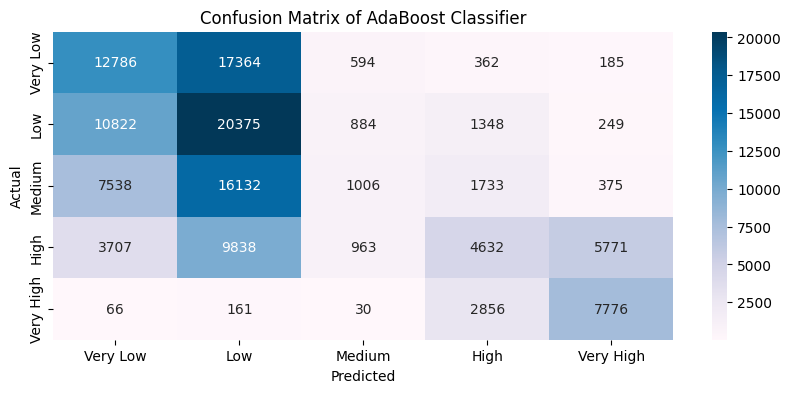

In [ ]:
# visualize a confusion matrix
cm_ada = confusion_matrix(y_test, y_pred_ada, labels=fema_data['bin'].unique())

plt.figure(figsize=(10, 4))
sns.heatmap(cm_ada, annot=True, fmt="g", cmap="PuBu", xticklabels=fema_data['bin'].unique(), yticklabels=fema_data['bin'].unique())

plt.title("Confusion Matrix of AdaBoost Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

Although AdaBoost excels in predicting the "Low" label among the three classifiers we employed, it exhibits an overall lower accuracy compared to Decision Tree and Random Forest, especially in the "Medium" labels.

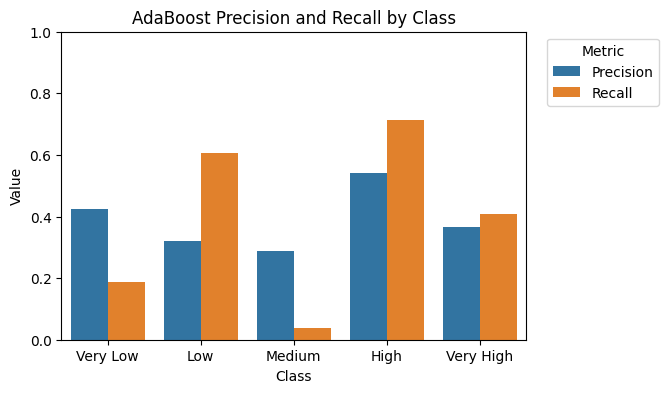

In [ ]:
# Show Precision and Recall
precision = precision_score(y_test, y_pred_ada, average=None)
recall = recall_score(y_test, y_pred_ada, average=None)

plot_df = pd.DataFrame({"Class" : fema_data['bin'].unique(), "Precision" : precision, "Recall" : recall})
plot_df = pd.melt(plot_df, 'Class')

plt.figure(figsize=(6, 4))
sns.barplot(data = plot_df, x = 'Class', y = 'value', hue='variable')
plt.title('AdaBoost Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend(title="Metric", fontsize=10, bbox_to_anchor=(1.3, 1))
plt.show()

Compared to Decision Tree and Random Forest, our precision and recall across all classes is generally lower. Medium in particular has very low recall.

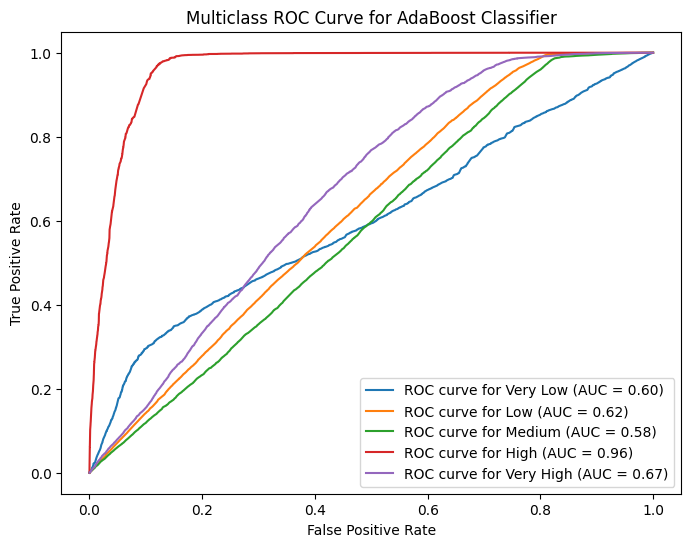

In [ ]:
#Multiclass ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))

y_score = ada.predict_proba(X_test)

for class_id, class_name in zip(range(len(fema_data['bin'].unique())), fema_data['bin'].unique()):
    RocCurveDisplay.from_predictions(
        y_binarizer[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_name}",
        ax=ax
    )

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for AdaBoost Classifier")
plt.legend()
plt.show()

Looking at the ROC curve, we can see particularly poor performance for the Very Low class as the False Positive Rate rises. Overall, AdaBoost does not seem to be a good model for our particular dataset.

### 7.2.4. Feed Forward Neural Networks (FNN)

Recognizing that none of the classifiers attain an accuracy surpassing 50%, we have opted to develop a Neural Network model to meet the requirement for capturing heightened complexity in our analysis. Feedforward Neural Networks (FNNs) excel in capturing intricate patterns and discerning non-linear relationships within the data.

In [ ]:
# check if GPU is available and setting up the device variable
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# convert categorical labels to numerical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# create tensor from train and test data
X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train_encoded).float().to(device)
y_test_tensor = torch.from_numpy(y_test_encoded).float().to(device)

In [ ]:
# verify the number of features and rows within the tensors
print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)

torch.Size([510212, 53]) torch.Size([127553, 53]) torch.Size([510212]) torch.Size([127553])


In [ ]:
# define an FNN model architecture
class FNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(53, 128)
    self.fc2 = nn.Linear(128, 5) # 10 classes
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten(start_dim=1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    outputs = self.fc2(x)

    return outputs

In [ ]:
# instantiate the FNN model and send it to the device
fnn = FNN().to(device)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-4)
epoch = 10
batch_size = 64

# initialize lists to store loss and accuracy
acc_list, loss_list = [], []

# build a generator function to create mini-batches
def get_batches(X, y, batch_size):
  for start in range(0, len(X), batch_size):
    end = start + batch_size
    yield X[start:end], y[start:end]

# train the model
for epoch in range(epoch):
  running_loss, correct, total = 0.0, 0, 0

  for inputs, labels in get_batches(X_train_tensor, y_train_tensor, batch_size):
    labels = labels.type(torch.LongTensor)
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad() # reset the optimizer gradients
    outputs = fnn(inputs) # feed the network the train data

    # get the prediction and compute loss
    predicted = torch.argmax(outputs.data, 1)
    loss = loss_criterion(outputs, labels)

    # do a back propagation
    loss.backward()
    optimizer.step()

    # accumulate loss and accuracy
    running_loss += loss.item()
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  # calculate training accuracy for each epoch
  accuracy = correct / total
  acc_list.append(accuracy)

  loss = running_loss / (len(X_train_tensor) // batch_size)
  loss_list.append(loss)

  print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

Epoch 0: Loss = 83.7800, Accuracy = 0.2308
Epoch 1: Loss = 43.2773, Accuracy = 0.2445
Epoch 2: Loss = 42.4313, Accuracy = 0.2539
Epoch 3: Loss = 39.4710, Accuracy = 0.2625
Epoch 4: Loss = 39.2217, Accuracy = 0.2669
Epoch 5: Loss = 40.0135, Accuracy = 0.2696
Epoch 6: Loss = 40.8762, Accuracy = 0.2736
Epoch 7: Loss = 40.6213, Accuracy = 0.2750
Epoch 8: Loss = 37.4034, Accuracy = 0.2781
Epoch 9: Loss = 36.5736, Accuracy = 0.2800


In [ ]:
# predict on the test set
total, correct = 0, 0
y_pred_fnn = []

with torch.no_grad():
  for i in range(0, len(X_test_tensor), batch_size):
    X_batch = X_test_tensor[i:i+batch_size].to(device)
    y_batch = y_test_tensor[i:i+batch_size].to(device)

    ouputs = fnn(X_batch)
    predicted = torch.argmax(ouputs.data, 1)
    y_pred_fnn.extend(predicted.cpu().numpy())

    total += y_batch.size(0)
    correct += (predicted == y_batch).sum()

# compute the accuracy
fnn_score_test = correct / total

print("< Feed Forward Neural Networks >")
print(f"Test Accuracy: {fnn_score_test.item():.4f}")

< Feed Forward Neural Networks >
Test Accuracy: 0.2798


Despite the numerous advantages of FNN, this model exhibited the lowest accuracy. This might be attributed to the fact that our dataset is relatively small in size, and Neural Networks typically thrive on larger datasets to unleash their full potential.

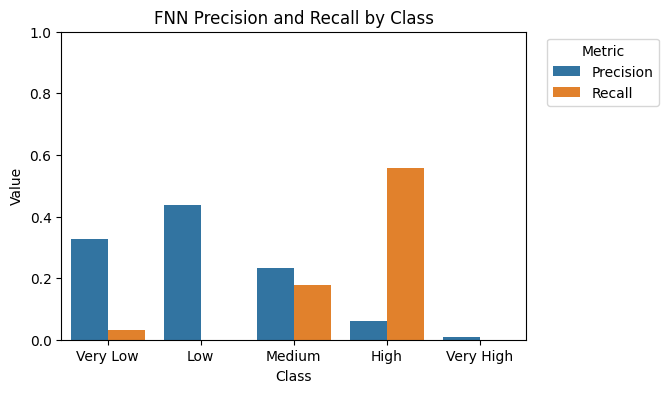

In [ ]:
# Show Precision and Recall
class_name_dict = {0:"Very Low", 1:"Low", 2:"Medium", 3:"High", 4:"Very High"}
y_pred_fnn_names = [class_name_dict[x] for x in y_pred_fnn]

precision = precision_score(y_test, y_pred_fnn_names, average=None)
recall = recall_score(y_test, y_pred_fnn_names, average=None)

plot_df = pd.DataFrame({"Class" : fema_data['bin'].unique(), "Precision" : precision, "Recall" : recall})
plot_df = pd.melt(plot_df, 'Class')

plt.figure(figsize=(6, 4))
sns.barplot(data = plot_df, x = 'Class', y = 'value', hue='variable')
plt.title('FNN Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend(title="Metric", fontsize=10, bbox_to_anchor=(1.3, 1))
plt.show()

Looking at the precision and recall graph, we can clearly see that the FNN poorly predicts across every class with lower precision and recall for every class.

In [ ]:
# compare the classification model performance
print(f"Decision Tree: {dt_score_test:.4f}")
print(f"Random Forest: {forest_score_test:.4f}")
print(f"AdaBoost: {ada_score_test:.4f}")
print(f"FNN: {fnn_score_test:.4f}")

Decision Tree: 0.4012
Random Forest: 0.4257
AdaBoost: 0.3651
FNN: 0.2798


Now, as we proceed to select our final model and undertake fine-tuning, we consider two pivotal criteria:

1. **Overall Accuracy:** Evaluating models based on total accuracy constitutes a fundamental method. Therefore, accuracy is considered one of the primary conditions. In this context, the Random Forest classifier attains the highest accuracy, registering at 0.4257.

2. **Precision and Recall** Comparing the precision and recall charts of the four models, Random Forest performed similar to Decision Tree with minor improvements, and it performed clearly better than AdaBoost and FNN across every class.

Consequently, factoring in these criteria, we have designated the **Random Forest Classifier** as our model to fine tune and use as our final model.

## 7.3 Fine Tuning

### 7.3.1 Hyperparameter Tuning for Random Forest

Now, we will proceed with tuning to identify the optimal parameters for the ultimately selected Random Forest and finalize the best model.

* `n_estimators` : This parameter represents the number of trees in the random forest. Increasing the number of trees generally improves the model's performance, but it comes with a trade-off in terms of computational cost. *We have set this parameter to '10', '30', '50', and '100'.*

* `max_depth` : This controls the maximum depth of each decision tree in the forest. A deeper tree can capture more complex relationships in the training data, but it also increases the risk of overfitting. *We have set this parameter to '10', '30', and 'None'.* ('None' indicates that there is no restriction on the maximum depth of the tree, and in our case, it will grow about 50)

* `max_features` : This parameter determines the maximum number of features considered for splitting a node in each decision tree. A smaller max_features can lead to more diverse trees, reducing the correlation between them and potentially improving the ensemble's performance. *We have set this parameter to 'sqrt', 'log2', and 'None'.*


In [ ]:
param_grid = {'n_estimators' : [10, 30, 50, 100], 'max_depth' : [10, 30, None], 'max_features' : ["sqrt", "log2", None]}
pgrid = ParameterGrid(param_grid)

In [ ]:
# conduct 80/20 train-validation split
seed = 0
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, train_size = 0.8, random_state = seed)

In [ ]:
best_acc = -np.math.inf
best_param = None

for param_dict in pgrid:
  # initialize model and fit it on the training set
  forest = RandomForestClassifier(n_estimators=param_dict['n_estimators'], random_state=0,
                                  max_depth=param_dict['max_depth'], max_features=param_dict['max_features'])
  forest.fit(X_train_split, y_train_split)

  # predict on the test set
  y_pred_forest = forest.predict(X_val)

  # compute the accuracies
  forest_score_train = forest.score(X_train_split, y_train_split)
  forest_score_val = forest.score(X_val, y_val)

  if best_acc < forest_score_val:
    best_acc = forest_score_val
    best_param = param_dict

  print("Random Forest parameters:", param_dict)
  print(f"Train Accuracy: {forest_score_train:.4f}")
  print(f"Validation Accuracy: {forest_score_val:.4f}")
  print("-" * 60)

Random Forest parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
Train Accuracy: 0.4049
Validation Accuracy: 0.3975
------------------------------------------------------------
Random Forest parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 30}
Train Accuracy: 0.4052
Validation Accuracy: 0.3979
------------------------------------------------------------
Random Forest parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
Train Accuracy: 0.4054
Validation Accuracy: 0.3977
------------------------------------------------------------
Random Forest parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Train Accuracy: 0.4065
Validation Accuracy: 0.3991
------------------------------------------------------------
Random Forest parameters: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
Train Accuracy: 0.4008
Validation Accuracy: 0.3919
------------------------------------------------------------

In [ ]:
print(f"The Best Validation Accuracy: {best_acc:.4f}")
print("The Best Parameters:", best_param)

The Best Validation Accuracy: 0.4239
The Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}


After thorough hyperparameter tuning, the Random Forest model achieved its best validation accuracy of 0.4239 with the selected parameters:

* `max_depth` : a maximum tree depth of 30
* `max_features` : no restrictions on the maximum number of features considered for splitting
* `n_estimators` : an ensemble of 100 trees.

### 7.3.2 Running the Tuned Model

In [ ]:
# initialize model and fit it on the training set
tuned_forest = RandomForestClassifier(n_estimators=100, random_state=0, max_depth = 30, max_features = 'sqrt')
tuned_forest.fit(X_train, y_train)

# predict on the test set
y_pred_tuned_forest = tuned_forest.predict(X_test)

# compute the accuracies
tuned_forest_score_train = tuned_forest.score(X_train, y_train)
tuned_forest_score_test = tuned_forest.score(X_test, y_test)

print("< Tuned Random Forest Classifier >\n")
print(f"Train Accuracy: {tuned_forest_score_train:.4f}")
print(f"Test Accuracy: {tuned_forest_score_test:.4f}")

< Tuned Random Forest Classifier >

Train Accuracy: 0.5527
Test Accuracy: 0.4283


As a result of fine-tuning, we have achieved a slightly higher accuracy in the test dataset. The increased number of estimators may have enabled the model to capture more complex patterns within the datasets. Additionally, setting the maximum depth of the trees may have effectively addressed overfitting, contributing to the improved performance.

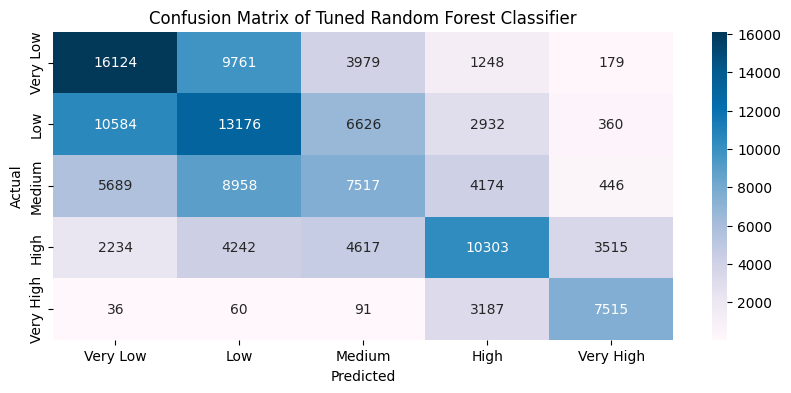

In [ ]:
# final confusion matrix
# visualize a confusion matrix
cm_forest = confusion_matrix(y_test, y_pred_tuned_forest, labels=fema_data['bin'].unique())

plt.figure(figsize=(10, 4))
sns.heatmap(cm_forest, annot=True, fmt="g", cmap="PuBu", xticklabels=fema_data['bin'].unique(), yticklabels=fema_data['bin'].unique())

plt.title("Confusion Matrix of Tuned Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

Comparing the Tuned confusion matrix to the previous random forest confusion matrix, we see very small improvements, but overall, very similar results.

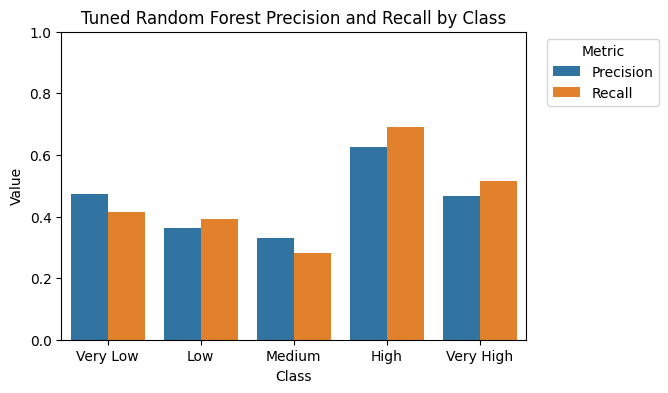

In [ ]:
# Show Precision and Recall
precision = precision_score(y_test, y_pred_tuned_forest, average=None)
recall = recall_score(y_test, y_pred_tuned_forest, average=None)

plot_df = pd.DataFrame({"Class" : fema_data['bin'].unique(), "Precision" : precision, "Recall" : recall})
plot_df = pd.melt(plot_df, 'Class')

plt.figure(figsize=(6, 4))
sns.barplot(data = plot_df, x = 'Class', y = 'value', hue='variable')
plt.title('Tuned Random Forest Precision and Recall by Class')
plt.xlabel('Class')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend(title="Metric", fontsize=10, bbox_to_anchor=(1.3, 1))
plt.show()

The precision and recall charts are roughly the same between the initial and tuned Random Forest.

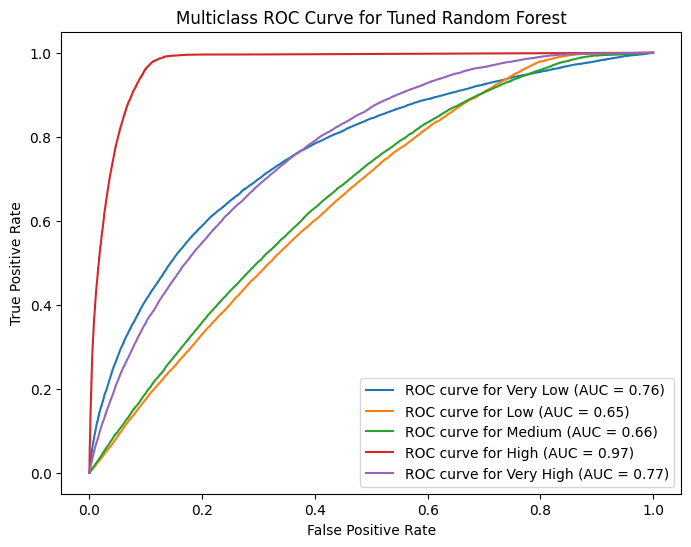

In [ ]:
#Multiclass ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))

y_score = tuned_forest.predict_proba(X_test)

for class_id, class_name in zip(range(len(fema_data['bin'].unique())), fema_data['bin'].unique()):
    RocCurveDisplay.from_predictions(
        y_binarizer[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_name}",
        ax=ax
    )

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for Tuned Random Forest")
plt.legend()
plt.show()

As with the precision and recall charts, comparing the ROC curves shows roughly equivalent performance before and after tuning.

# Part 8 : Conclusion

#### **Critical Findings**
1. The factors influencing the allocation of assistance funds appear more intricate than initially hypothesized, leading to low accuracy across all regression models. However, there was a notable improvement in overall accuracy observed within classification models. This suggests that while the current dataset exhibits some capability in delineating general trends, it remains insufficient to comprehensively encapsulate all nuanced details.

2. Upon analyzing the decision tree graph, it became evident that factors we anticipated as additional contributors, such as disaster durations and employment features (e.g., unemployment rate and labor force), indeed yield significant influence over the allocation of assistance funds. This observation aligns with our initial hypotheses.

3. The most effective model found was Random Forest, optimized with a maximum tree depth of 30, an ensemble comprising 100 trees, and no restrictions on the maximum number of features. This model achieved an accuracy rate of 0.4286 and appeared to be most accurate when predicting the "high" levels of funding amounts.

The insights gleaned from our analysis provide us with a greater understanding of the complex dynamics between natural disasters and FEMA allocated assistance funds.


#### **Challenges and Limitations**

1. Many of our feature columns had to be one-hot encoded because our model mostly consisted of categorical variables. This led to high dimensional data that was difficult to work with when designing our model.

2. Our original plan to analyze natural disasters and economic impacts had to be altered because we did not have enough individual disasters to conduct a "big" data analysis.

3. Creating the classification bins proved to be difficult as well. When evenly splitting the data, the confusion matrices predicted the central bins very poorly, so we decided to manually create the bins. This resulted in a slightly unbalanced distribution, but we feel it captured the data in a better way showing a decent confusion matrix and allowing the results to be more human interpretable.

#### **Path Forward**

1. Enhancing the complexity of predictive models can be achieved by integrating more structured datasets. For instance, incorporating detailed damage metrics, such as mortality and injury rates per incident, can significantly refine the prediction of assistance fund requirements. Furthermore, augmenting this with comprehensive climate data as a more nuanced extension of weather information can offer valuable insights. The severity of incidents often varies based on temperature and weather conditions, even within similar disaster types.

2. Augmenting the dataset with additional unstructured data, such as real-time textual information sourced from X or keyword search volumes obtained through web scraping from platforms like Google, can be instrumental. Employing Natural Language Processing (NLP) techniques on such data can indirectly aid in predicting the impact of natural disasters. The substantial volume of these data sources has the potential to enhance the model's complexity significantly.

3. With a larger and more diverse dataset, an intriguing prospect emerges: the integration of unsupervised learning results into supervised learning methodologies. Previous limitations stemmed from insufficient data for combining both modeling techniques. However, an expanded dataset allows for the grouping of the entire dataset into clusters, enabling the application of distinct supervised learning approaches tailored to the characteristics of each cluster.

This comprehensive approach, leveraging both structured and unstructured data while considering supervised and unsupervised learning techniques, could substantially enhance the depth and accuracy of predictive models for natural disaster economic impacts.


# Thank you for reading! 🙌